<a href="https://colab.research.google.com/github/AmitNG2000/AWS-Cloud-Computing/blob/master/code/Key_Authors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README

## Overview
This notebook processes and analyzes a raw data from social netwrok in order to identify **key authors** and their relationships.  
It is designed to work with tabular input data and produce insights into author connections and creeats *backbone graphs* contens only the *key authors*.

## Required Columns
The input dataset must contain the following columns:

- **c_post_id**: Unique identifier for each post (numeric or string).
- **title**: Name or numeric id of the topic.
- **content**: The text of the post (include hastagas, URLs and more)
- **date**:  Reperention that is converable to *panda.datetime64*.
- **author**: Unique name of the author.

> ⚠️ If your dataset is missing any of these required columns, the notebook will not run correctly.



# Imports

In [ ]:
# !pip install tweetnlp

In [2]:
import pickle
import re
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfTransformer
import pprint
from tabulate import tabulate
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Load tokenizer + model
tokenizer = AutoTokenizer.from_pretrained("TweebankNLP/bertweet-tb2_wnut17-ner")
model = AutoModelForTokenClassification.from_pretrained("TweebankNLP/bertweet-tb2_wnut17-ner")

# Build NER pipeline
nlp = pipeline("token-classification", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Load Data

In [4]:
# Connect to Goole Drive to use the data.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_dir = "/content/drive/Shareddrives/KeyBoostAuthor/data/"

output_file = output_dir + "df_with_relevant_partial.csv"
filter= pd.read_csv(output_file)
filter = filter[filter['relevance'] == 'RELEVANT']

#this is the ids of the post that are rellevnt to the topic.

In [ ]:

# # Load Data
# output_dir = "/content/drive/Shareddrives/KeyBoostAuthor/data/"
# # output_dir = "/dt/puzis/cnalab/KeyAuthors/"

# with open(output_dir + '/israel_and_the_region.pkl', 'rb') as f:
#     df = pickle.load(f)

# # Print df
# df.head()

In [ ]:
output_dir = "/content/drive/Shareddrives/KeyBoostAuthor/data/"

df_1 = pd.read_excel(output_dir + '2_claims.xlsx')
df_2 = pd.read_excel(output_dir + '100_politics.xlsx')
df = pd.concat([df_1, df_2])

In [ ]:
df.drop_duplicates(inplace=True)
df.shape

(118464, 16)

In [ ]:
df = df[df['c_post_id'].isin(filter.c_post_id)]

In [ ]:
df.drop_duplicates(subset="c_post_id", inplace=True)


In [ ]:
df.shape

(13450, 10)

## Save DataFrame As Execl

In [ ]:
# To be used when nececery
def save_filtered_df_to_excel(df, topic_id, authors):
    """
    Filter the DataFrame by topic and authors, then save the result to an Excel file.
    Args:
        df (pd.DataFrame): The original DataFrame.
        topic_id (int or str): The topic ID to filter.
        authors (list): List of authors to include.
    Returns:
        None
    """
    # Filter by topic and authors
    filtered_df = df[(df['topic'] == topic_id) & (df['author'].isin(authors))]
    filtered_df['date'] = pd.to_datetime(filtered_df['date'])

    # Save to Excel
    filename = f"filtered_{topic_id}_posts.xlsx"
    filtered_df.to_excel(filename, index=False)
    files.download(filename)

# Data Preprocessing

In [ ]:
df = df[['c_post_id', 'title', 'content', 'date', 'author', 'description', 'url_right']]

In [ ]:
# Encode 'title' categories as numeric codes in 'topic' column
df['topic'] = df['title'].astype('category').cat.codes

df['date'] = df['date'].astype('datetime64[ns]')

#{topic_id: topic}
topic_id_to_title = dict(enumerate(df['title'].astype('category').cat.categories))

In [ ]:
df.head()

c_post_id  \
1   0052b60f-d4a0-376a-8b20-31272deb8436   
22  02b38211-d4c9-316d-a858-fad3ec416029   
31  048e67cb-6380-37be-aa84-28be3efb6c0a   
35  04c0806b-b246-344f-abea-e3f6f00488d2   
41  05249800-c7ce-3acd-af25-8a40715b8e92   

                                                title  \
1   Scott Walker's big re-election tax cut tout: $...   
22  Scott Walker's big re-election tax cut tout: $...   
31  Scott Walker's big re-election tax cut tout: $...   
35  Scott Walker's big re-election tax cut tout: $...   
41  Scott Walker's big re-election tax cut tout: $...   

                                              content                date  \
1   Mitt Romney's job creation record in MA was 47... 2012-11-06 05:32:20   
22  Mitt Romney's job creation record in MA was 47... 2012-10-25 05:32:38   
31  Mitt Romney's job creation record in MA was 47... 2012-10-11 05:33:58   
35  not in this state,i wish i didnt have to say t... 2016-10-20 23:38:22   
41  Walkers (snack foods) : The Big Myth in Wiscon... 2011-02-28 15:00:09   

            author        description  \
1   SmPenisGunClub  In May 2017, Gov.   
22    POTUSWillard  In May 2017, Gov.   
31  SmPenisGunClub  In May 2017, Gov.   
35        SNBEllis  In May 2017, Gov.   
41   jamescamron82  In May 2017, Gov.   

                                            url_right  topic hashtags  \
1   https://www.politifact.com/wisconsin/statement...     36       []   
22  https://www.politifact.com/wisconsin/statement...     36       []   
31  https://www.politifact.com/wisconsin/statement...     36       []   
35  https://www.politifact.com/wisconsin/statement...     36       []   
41  https://www.politifact.com/wisconsin/statement...     36       []   

   user_mentions  
1             []  
22            []  
31            []  
35            []  
41            []

In [ ]:
# Wrap long text in the 'content' column to a max width so it will be printed nicely.
from textwrap import fill
df['content'] = df['content'].apply(lambda x: fill(str(x), width=60))

# Load from "Labeled Datasets for Research on Information Operations"


[Dataset](https://zenodo.org/records/14189193)


In [6]:
file_path = "/content/drive/Shareddrives/KeyBoostAuthor/Labeled_Datasets/Ecuador/Ecuador_part_3.gzip.parquet"

df = pd.read_parquet(file_path)

In [7]:
total_posts = len(df)
hashtag_posts = df[df['hashtags'].notna() & (df['hashtags'].str.len() > 0)]
mention_posts = df[df['account_mentions'].notna() & (df['account_mentions'].str.len() > 0)]
url_posts = df[df['urls'].notna() & (df['urls'].str.len() > 0)]

print(f"{'df shape:':<40} {df.shape}")
print(f"{'df posts with hashtags # shape:':<40} {hashtag_posts.shape}  ({len(hashtag_posts)/total_posts*100:.2f}%)")
print(f"{'df posts with account_mentions @ shape:':<40} {mention_posts.shape}  ({len(mention_posts)/total_posts*100:.2f}%)")
print(f"{'df posts with urls shape:':<40} {url_posts.shape}  ({len(url_posts)/total_posts*100:.2f}%)")


print()
print()

print(f"{'**collum name**':<30} **value type**")
for col in df.columns:
    dtype_str = str(df[col].dtype)  # Convert dtype to string
    # get a sample non-null value if exists
    sample_val = df[col].dropna().iloc[0] if df[col].notna().any() else None
    print(f"{col:<30} | {type(sample_val).__name__}")


print()
print()
print(df['post_language'].value_counts().head())

df shape:                                (50000, 19)
df posts with hashtags # shape:          (22419, 19)  (44.84%)
df posts with account_mentions @ shape:  (31089, 19)  (62.18%)
df posts with urls shape:                (18968, 19)  (37.94%)


**collum name**                **value type**
postid                         | str
post_text                      | str
application_name               | str
post_language                  | str
in_reply_to_postid             | str
in_reply_to_accountid          | str
post_time                      | Timestamp
accountid                      | str
account_profile_description    | str
follower_count                 | int64
following_count                | int64
account_creation_date          | date
is_repost                      | bool
reposted_accountid             | str
reposted_postid                | str
hashtags                       | ndarray
urls                           | ndarray
account_mentions               | ndarray
is_control          

In [ ]:
# post in english with hatags
df[ (df['post_language'] == 'en') & df['hashtags'].notna() & (df['hashtags'].str.len() > 0) ]['is_control'].value_counts()

is_control
True     4455
False      45
Name: count, dtype: int64

In [ ]:
# adjust the df to the previes format

df = df.rename(columns={
    'postid': 'c_post_id',
    'post_text': 'content',
    'post_time': 'date',
    'accountid': 'author',
    'account_mentions': 'user_mentions',
})

# Add placeholder for columns that don't exist
df['title'] = 'title'
df['topic'] = 0
df['description'] = 'description'
df['url_right'] = 'url_right'



# Reorder columns
df = df[['c_post_id','topic', 'title', 'content', 'date', 'author', 'description', 'urls', 'url_right', 'hashtags', 'user_mentions']]

topic_id_to_title = {0 : 'topic0'}

# Topic Clastering

In [9]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import pandas as pd

In [13]:
# df = df.head() # for exmple

# embeddings
model = SentenceTransformer("digio/Twitter4SSE")
embeddings = model.encode(df['post_text'].to_list())
embeddings = normalize(embeddings)

# Clastering
k = 3
km = KMeans(n_clusters=k, random_state=42, n_init="auto")
cluster_labels = km.fit_predict(embeddings)
df['topic'] = cluster_labels


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [14]:
df.head()

postid  \
100000  43394c24c54037f763e8318026ffba9aeb9317f672   
100001  1b6cb8bafe65e8b9e639b7e52075c8ebf34d854d6c   
100002  4b69e40a8e23031f7ddc3832dfe5f289e851b56299   
100003  f810b69a925e539fb18b86ad0d227751cf072738bd   
100004  94e00228f2ac99ef8ae06ab1c5419e74dfd7dc4699   

                                                post_text  \
100000  Queda prohibido no sonreir a los problemas, no...   
100001  Te encontraras con gente hipócrita, con amigos...   
100002  Aventarle un diccionario a alguien en la cabez...   
100003  Suena mi alarma del celu, tendre que levantarm...   
100004  En el mar la vida es mas sabrosa 8' @5b3c3e3a2...   

                                  application_name post_language  \
100000  2727201c363b6fc4afe259ba4094ae0c49cb4df224          None   
100001  62010408238d4a0f958ec97eec3db0a4f69bcd0d11            es   
100002  62010408238d4a0f958ec97eec3db0a4f69bcd0d11            es   
100003  62010408238d4a0f958ec97eec3db0a4f69bcd0d11            es   
100004  e278f5ccf53957cccf9e97b2ae3fec72d5b892f850          None   

       in_reply_to_postid in_reply_to_accountid           post_time  \
100000               None                  None 2013-02-21 16:02:00   
100001               None                  None 2013-02-21 16:04:04   
100002               None                  None 2013-02-21 16:04:12   
100003               None                  None 2013-02-21 16:04:16   
100004               None                  None 2013-02-21 16:15:00   

                                         accountid  \
100000  71cc57155d061d447c2c65756c7dfd6873e403a097   
100001  8949eab1b3f746ed66a069ae5d6c415a57dc546ffc   
100002  8949eab1b3f746ed66a069ae5d6c415a57dc546ffc   
100003  8949eab1b3f746ed66a069ae5d6c415a57dc546ffc   
100004  4a08f9f3e1b73d62e982f899cdfb644e2101bd28a4   

                              account_profile_description  follower_count  \
100000                                         🍃🧚‍♀️🧜‍♀️👑            3618   
100001  Agradecida con Dios y con la Vida.  Ahora en #...             471   
100002  Agradecida con Dios y con la Vida.  Ahora en #...             471   
100003  Agradecida con Dios y con la Vida.  Ahora en #...             471   
100004                                          Grateful💕             587   

        following_count account_creation_date  is_repost  \
100000             2055            2009-12-22       True   
100001              233            2010-08-25      False   
100002              233            2010-08-25      False   
100003              233            2010-08-25       True   
100004              270            2010-06-06       True   

                                reposted_accountid  \
100000  5ff80261b935621244fb38fff05231bf108ba8a488   
100001                                        None   
100002                                        None   
100003  7e6b7dd1aa865b143fc37f4181e392613d1e6dfe3f   
100004  ad1f5918aa283b31785d589c2ade1c1ca176a23a47   

                                   reposted_postid hashtags  \
100000  4af2ce0fdafbc22f1a0be317a2f1025f2b18983194       []   
100001                                        None       []   
100002                                        None       []   
100003  e6e93d6dcfdca0ea6ba2104dc6532ade3f85263147       []   
100004  4e9a2c4ec3f5bb6ec24e2936e287ac2fa33b30245d       []   

                                                     urls  \
100000                                                 []   
100001                                                 []   
100002                                                 []   
100003                                                 []   
100004  [https://f87702c9a584719155693093bf96b50d218e8...   

                                         account_mentions  is_control  topic  
100000       [5ff80261b935621244fb38fff05231bf108ba8a488]       False      2  
100001                                                 []        True      0  
100002                                                 []  

# Extracting Key Entity

In [ ]:
# Extracting hashtags and user mentions from a text
import re

def extract_hashtags(text: str):
    """
    Extract valid hashtags from text.
    Rules:
      - Remove spaces inside hashtags
      - Exclude hashtags containing URLs or 'pic.twitter.com'
      - Exclude hashtags with only digits
      - Exclude technical or meaningless tags
    """
    raw_hashtags = re.findall(r'#\s*[\w\.]+', text)
    cleaned_hashtags = [re.sub(r'\s+', '', h) for h in raw_hashtags]

    blacklist = {
        "#because", "#and", "#or", "#if", "#when", "#the", "#then", "#keep",
        "#this", "#that", "#from", "#to", "#in", "#on", "#gov",
        "#amp", "#fwhttps", "#bitly", "#url", "#link"
    }

    valid_hashtags = []
    for h in cleaned_hashtags:
        h_lower = h.lower()
        if any(x in h_lower for x in ("http", "https", "pic.twitter.com", "twitter.com")):
            continue
        if len(h) <= 2 or h[1:].isdigit():
            continue
        if h_lower in blacklist:
            continue
        valid_hashtags.append(re.sub(r'[^#\w]+$', '', h_lower))

    return valid_hashtags




def extract_user_mentions(text: str):
    """
    Extract valid user mentions from text.
    Rules:
      - Must start with '@'
      - Exclude mentions with only 1 character
      - Exclude mentions that are only digits
      - Exclude mentions starting with 'http' or 'https'
    """
    mention_pattern = r'@\w+'
    mentions = re.findall(mention_pattern, text)

    blacklist = {
            "@because", "@and", "@or", "@if", "@when", "@the", "@then", "@keep",
            "@this", "@that", "@from", "@to", "@in", "@on", "@gov"
        }

    valid_mentions = [
            m for m in mentions
            if (
                len(m) > 2
                and not m[1:].isdigit()
                and not m[1:].lower().startswith(("http", "https", "gmail", "post", "amp", "fwhttps"))
                and m.lower() not in blacklist
            )
        ]
    return valid_mentions


def extract_ner_entities(text):
  entities = nlp(text)
  entity_words = [e['word'] for e in entities]
  clean_entities = [e['word'].replace('@@', '').strip() for e in entities]
  return clean_entities



# Example usage with DataFrame
df['hashtags'] = df['content'].apply(extract_hashtags)
df['user_mentions'] = df['content'].apply(extract_user_mentions)
df['ner'] = df['content'].apply(extract_ner_entities)

In [ ]:

import re
import requests

def extract_urls(text):
    url_pattern = r'https?://\S+'
    urls = re.findall(url_pattern, text)
    return urls

df['urls'] = df['content'].apply(extract_urls)
# Note: the urls can be a shorterer verstion and need to be expand

# Entities' Frequency

In [ ]:
def topic_entities_freq(df, topic_id, entity_col_name) -> dict:
    """
    Calculate the normalized usage percentage of each entity (e.g., hashtag, mention) within a given topic.
    Args:
        df (pd.DataFrame): DataFrame containing at least ['topic', entity_col_name] columns.
        topic_id (int or str): The topic ID to filter by.
        entity_col_name (str): The name of the column containing lists of entities (e.g., 'hashtags').
    Returns:
        dict: {entity : usege percentage}
    """
    topic_df = df[df['topic'] == topic_id]
    total_posts_num = len(topic_df)  # number of posts in the topic
    entities_freq = topic_df[entity_col_name].explode().dropna().value_counts()
    return ((entities_freq / total_posts_num) * 100).to_dict()

# TF_IDF
We use *TF-IDF* to identify which entities (e.g. hashtag or mention) are most important to each topic by measuring how frequently they appear in a topic and how unique they are across all topics.  
In *TF-IDF terminology*, we treat each **topic** as a **document** and each **entity**  as a **term**.


## Calculating entities TF-IDF score

### Calculating TF


TF<sub>t,e</sub> = count(e ∈ t) / ∑<sub>e′</sub> count(e′ ∈ t)

In [ ]:
def compute_tf_entity_by_topic(df, topic_col_name, entity_col_name):
    """
    Computes normalized term frequency of entities per topic.
    Args:
        df (DataFrame): Input DataFrame.
        topic_col_name (str): Column name with topic IDs.
        entity_col_name (str): Column name with lists of entities.
    Returns:
        dict: {topic: {entity: normalized_frequency}}
    """
    tf = defaultdict(lambda: defaultdict(int))

    # Count entity instances in the topic
    for _, row in df.iterrows():
        topic = row[topic_col_name] #the numeric uniq value of the topic.
        entities = row[entity_col_name]
        for entity in entities:
            tf[topic][entity] += 1

    # Normalize counts by total number of entities in each topic
    for topic in tf:
        total = sum(tf[topic].values())
        if total > 0:
            for entity in tf[topic]:
                tf[topic][entity] /= total

    return tf
'''
Idea 1: Use `lowercase()` or remove-spaces on entities as a form of stemming suitable for social media.
Idea 2: Use a logarithmic formula to handle big data.
'''

tf_hashtags = compute_tf_entity_by_topic(df, topic_col_name='topic', entity_col_name='hashtags')
tf_urls = compute_tf_entity_by_topic(df, topic_col_name='topic', entity_col_name='urls')
tf_mentions = compute_tf_entity_by_topic(df, topic_col_name='topic', entity_col_name='user_mentions')
tf_author = compute_tf_entity_by_topic(df, topic_col_name='topic', entity_col_name='author')

# pprint.pprint(tf_hashtags)

### Calculating DF

DF<sub>e</sub> = ∑<sub>{ t | e ∈ t} </sub> 1


In [ ]:
# Calculate DF (document frequency)

def compute_document_frequency(tf_dict):
    """
    Counts how many topics each entity appears in.
    Args:
        tf_dict (dict): {topic: {entity: tf_value}}
    Returns:
        dict: {entity: document_frequency}
    """
    df_dict = defaultdict(int)
    for topic, entities_dict in tf_dict.items():
        for entity in entities_dict:
            df_dict[entity] += 1
    return df_dict

df_hashtags = compute_document_frequency(tf_hashtags)
df_urls = compute_document_frequency(tf_urls)
df_mentions = compute_document_frequency(tf_mentions)
df_author = compute_document_frequency(tf_author)

### Calculating IDF

IDF<sub>e</sub> = [ log( (N + smooth) / (DF<sub>e</sub> + smooth) ) + offset ]<sup>α</sup>


In [ ]:
import numpy as np

def compute_idf(num_of_topics, df_dict, use_log=True, smooth_value=1.0, offset=1.0, alpha=1.0):
    """
    Compute a IDF (Inverse Document Frequency) for each entity.
    Args:
        num_of_topics (int): Total number of topics (documents).
        df_dict (dict): Mapping {entity: document frequency}.
        use_log (bool, optional): Whether to use logarithmic scaling. Default True.
        smooth_value (float, optional): Added to numerator & denominator for smoothing. Default 1.0.
        offset (float, optional): Added to the log result to keep it positive. Default 1.0.
        alpha (float, optional): Power factor for scaling IDF influence (0.5–2 range). Default 1.0.
    Returns:
        dict: {entity: idf_score}
    """
    idf_dict = {}

    for entity, df_score in df_dict.items():

        # Smoothed ratio
        idf_score = (num_of_topics + smooth_value) / (df_score + smooth_value)

        # Log
        if use_log:
          idf_score = np.log(idf_score)

        # Add offset
        idf_score += offset

        # Apply scaling
        idf_score = np.power(idf_score, alpha)

        idf_dict[entity] = idf_score

    return idf_dict


In [ ]:
num_of_topics = len(topic_id_to_title)

idf_hashtags = compute_idf(num_of_topics, df_hashtags)
idf_urls = compute_idf(num_of_topics, df_urls)
idf_mentions = compute_idf(num_of_topics, df_mentions)
idf_author = compute_idf(num_of_topics, df_author)

### Calculating TF * IDF

TF-IDF<sub>t,e</sub> = TF<sub>t,e</sub> * DF<sub>e</sub>

In [ ]:
def compute_entity_tfidf_scores(entity_tf_dict, entity_idf_dict):
    """
    Computes TF-IDF scores per entity per topic.
    Args:
        entity_tf_dict (dict): {topic: {entity: tf_value}}
        entity_idf_dict (dict): {entity: idf_value}
    Returns:
        dict: {topic: {entity: tfidf_score}}
    """
    entity_tfidf_dict = defaultdict(lambda: defaultdict(float))
    for topic, entity_tf_counts_dict in entity_tf_dict.items():
        for entity, tf in entity_tf_counts_dict.items():
            idf = entity_idf_dict[entity]
            entity_tfidf_dict[topic][entity] = tf * idf
    return entity_tfidf_dict

hashtags_tfidf_dict = compute_entity_tfidf_scores(tf_hashtags, idf_hashtags)
urls_tfidf_dict = compute_entity_tfidf_scores(tf_urls, idf_urls)
mention_tfidf_dict = compute_entity_tfidf_scores(tf_mentions, idf_mentions)

## Calculating Posts TF-IDF Score

TF-IDF<sub>topic,post</sub> = ∑<sub>e ∈ post</sub> TF-IDF<sub>topic,e</sub>


In [ ]:
def compute_post_entities_tfidf_scores(row, entity_tfidf_dict, entity_type, topic_col_name='topic'):
    """
    Calculate the total TF-IDF score for one entity type in a post's topic.
    Args:
        row (pd.Series): A row from the DataFrame.
        entity_tfidf_dict (dict): {topic: {entity: tfidf_score}}.
        entity_type (str): The entity column in the row (e.g., 'hashtags', 'mentions').
        topic_col_name (str): Name of the topic column.
    Returns:
        float: Total TF-IDF score for that entity type in the post.
    """
    topic = row[topic_col_name]
    entities = row.get(entity_type, [])
    entities_scores = [entity_tfidf_dict[topic].get(entity, 0) for entity in entities]
    return entities_scores


df['hashtag_scores'] = df.apply(compute_post_entities_tfidf_scores, axis=1, args=(hashtags_tfidf_dict, 'hashtags'))
df['mention_scores'] = df.apply(compute_post_entities_tfidf_scores, axis=1, args=(mention_tfidf_dict, 'mentions'))
df['url_scores']     = df.apply(compute_post_entities_tfidf_scores, axis=1, args=(urls_tfidf_dict, 'urls'))

df.head()

c_post_id  topic  title  \
100000  43394c24c54037f763e8318026ffba9aeb9317f672      0  title   
100001  1b6cb8bafe65e8b9e639b7e52075c8ebf34d854d6c      0  title   
100002  4b69e40a8e23031f7ddc3832dfe5f289e851b56299      0  title   
100003  f810b69a925e539fb18b86ad0d227751cf072738bd      0  title   
100004  94e00228f2ac99ef8ae06ab1c5419e74dfd7dc4699      0  title   

                                                  content                date  \
100000  Queda prohibido no sonreir a los problemas, no... 2013-02-21 16:02:00   
100001  Te encontraras con gente hipócrita, con amigos... 2013-02-21 16:04:04   
100002  Aventarle un diccionario a alguien en la cabez... 2013-02-21 16:04:12   
100003  Suena mi alarma del celu, tendre que levantarm... 2013-02-21 16:04:16   
100004  En el mar la vida es mas sabrosa 8' @5b3c3e3a2... 2013-02-21 16:15:00   

                                            author  description  \
100000  71cc57155d061d447c2c65756c7dfd6873e403a097  description   
100001  8949eab1b3f746ed66a069ae5d6c415a57dc546ffc  description   
100002  8949eab1b3f746ed66a069ae5d6c415a57dc546ffc  description   
100003  8949eab1b3f746ed66a069ae5d6c415a57dc546ffc  description   
100004  4a08f9f3e1b73d62e982f899cdfb644e2101bd28a4  description   

                                                     urls  \
100000                                                 []   
100001                                                 []   
100002                                                 []   
100003                                                 []   
100004  [https://f87702c9a584719155693093bf96b50d218e8...   

                                                url_right hashtags  \
100000                                                 []       []   
100001                                                 []       []   
100002                                                 []       []   
100003                                                 []       []   
100004  [https://f87702c9a584719155693093bf96b50d218e8...       []   

                                            user_mentions hashtag_scores  \
100000       [5ff80261b935621244fb38fff05231bf108ba8a488]             []   
100001                                                 []             []   
100002                                                 []             []   
100003       [7e6b7dd1aa865b143fc37f4181e392613d1e6dfe3f]             []   
100004  [ad1f5918aa283b31785d589c2ade1c1ca176a23a47, 5...             []   

       mention_scores               url_scores  post_topic_tfidf  author_score  
100000             []                       []               0.0      13.44035  
100001             []                       []               0.0       0.00047  
100002             []                       []               0.0       0.00047  
100003             []                       []               0.0       0.00047  
100004             []  [5.054589567327133e-05]               0.0       0.19006

In [ ]:
def compute_post_tfidf_score(row, entity_score_column_names=['hashtag_scores', 'mention_scores']): #, 'url_scores'
    """
    Sum the TF-IDF score for all entity types in a single post.
    Args:
        row (pd.Series): A single row from the DataFrame (used with pd.apply()).
        entity_score_column_names (list): Column names containing lists of TF-IDF scores for each entity type.
    Returns:
        float: Total TF-IDF score for the post.
    """
    post_total_score = 0
    for column in entity_score_column_names:
        post_total_score += sum(row[column])
    return post_total_score

df['post_topic_tfidf'] = df.apply(compute_post_tfidf_score, axis=1)
df.head()

c_post_id  topic  title  \
100000  43394c24c54037f763e8318026ffba9aeb9317f672      0  title   
100001  1b6cb8bafe65e8b9e639b7e52075c8ebf34d854d6c      0  title   
100002  4b69e40a8e23031f7ddc3832dfe5f289e851b56299      0  title   
100003  f810b69a925e539fb18b86ad0d227751cf072738bd      0  title   
100004  94e00228f2ac99ef8ae06ab1c5419e74dfd7dc4699      0  title   

                                                  content                date  \
100000  Queda prohibido no sonreir a los problemas, no... 2013-02-21 16:02:00   
100001  Te encontraras con gente hipócrita, con amigos... 2013-02-21 16:04:04   
100002  Aventarle un diccionario a alguien en la cabez... 2013-02-21 16:04:12   
100003  Suena mi alarma del celu, tendre que levantarm... 2013-02-21 16:04:16   
100004  En el mar la vida es mas sabrosa 8' @5b3c3e3a2... 2013-02-21 16:15:00   

                                            author  description  \
100000  71cc57155d061d447c2c65756c7dfd6873e403a097  description   
100001  8949eab1b3f746ed66a069ae5d6c415a57dc546ffc  description   
100002  8949eab1b3f746ed66a069ae5d6c415a57dc546ffc  description   
100003  8949eab1b3f746ed66a069ae5d6c415a57dc546ffc  description   
100004  4a08f9f3e1b73d62e982f899cdfb644e2101bd28a4  description   

                                                     urls  \
100000                                                 []   
100001                                                 []   
100002                                                 []   
100003                                                 []   
100004  [https://f87702c9a584719155693093bf96b50d218e8...   

                                                url_right hashtags  \
100000                                                 []       []   
100001                                                 []       []   
100002                                                 []       []   
100003                                                 []       []   
100004  [https://f87702c9a584719155693093bf96b50d218e8...       []   

                                            user_mentions hashtag_scores  \
100000       [5ff80261b935621244fb38fff05231bf108ba8a488]             []   
100001                                                 []             []   
100002                                                 []             []   
100003       [7e6b7dd1aa865b143fc37f4181e392613d1e6dfe3f]             []   
100004  [ad1f5918aa283b31785d589c2ade1c1ca176a23a47, 5...             []   

       mention_scores               url_scores  post_topic_tfidf  author_score  
100000             []                       []               0.0      13.44035  
100001             []                       []               0.0       0.00047  
100002             []                       []               0.0       0.00047  
100003             []                       []               0.0       0.00047  
100004             []  [5.054589567327133e-05]               0.0       0.19006

## Sum Author Posts Score

In [ ]:
def sum_author_posts_score(df, topic_col_name='topic', author_col_name='author', post_tfidf_col_name='post_topic_tfidf'):
    """
    Aggregate TF-IDF scores per author per topic based on sum of post-level TF-IDF.
    Args:
        df (DataFrame): The input DataFrame with author, topic, and post TF-IDF columns.
        topic_col_name (str): Column name containing topic identifiers.
        author_col_name (str): Column name containing authors (as single-element lists).
        post_tfidf_col_name (str): Column with the post-level total TF-IDF score.
    Returns:
        dict: {topic: {author: total_tfidf_score}}
    """
    author_posts_score_sum_dict = defaultdict(lambda: defaultdict(float))
    for _, row in df.iterrows():
        topic = row[topic_col_name]
        author = row[author_col_name]
        author_posts_score_sum_dict[topic][author] += row[post_tfidf_col_name]
    return authors_tfidf_dict

In [ ]:
# author_posts_score_sum_dict = sum_author_posts_score(df)
# df['author_posts_score_sum'] = df.apply(lambda row: author_posts_score_sum_dict[row['topic']][row['author']], axis=1)

## Calculating Authors TF-IDF Score

IDF<sub>a</sub> = log( |all_topics| / |author's_topics| ) + offset

TF-IDF<sub>t,a</sub> = ∑<sub>{p ∈ authors's posts}</sub> TF-IDF<sub>t,p</sub> * IDF<sub>a</sub>

In [ ]:
def compute_focused_tfidf_scores(df, topic_col_name='topic', author_col_name='author', post_tfidf_col_name='post_topic_tfidf', use_log_idf = True, offset = 1.0):
    """
    Compute adjusted author-topic TF-IDF scores giving preference to topic specipic autothers.
    Args:
        df (pd.DataFrame)
        topic_col_name (str): Name of the column representing the topic.
        author_col_name (str): Name of the column representing the author.
        post_tfidf_col_name (str): Name of the column representing the post-level TF-IDF score.
        use_log_idf (bool): Whether to use logarithmic scaling for IDF.
        offset (float): Added to the log result to keep it positive.
    Returns:
        authors_tfidf_dict (dict): {topic: {author: tfidf_score}}
    """

    # Sum the tf-idf score of all the auter's posts.
    # Count number of unique topics per author.
    authors_sum_posts_score_dict = defaultdict(lambda: defaultdict(float))  # {topic: {author: tfidf_score}}
    author_topics_dict = defaultdict(set)  # {author : set of topics}
    for _, row in df.iterrows():
        author = row[author_col_name]
        topic = row[topic_col_name]
        authors_sum_posts_score_dict[topic][author] += row[post_tfidf_col_name] #sum autor posts' scors
        author_topics_dict[author].add(topic)

    total_topics = df[topic_col_name].nunique()

    # Compute final TF-IDF scores with log-scaled focus
    authors_tfidf_dict = defaultdict(lambda: defaultdict(float))
    for topic in authors_sum_posts_score_dict: # go over all the topics
        for author in authors_sum_posts_score_dict[topic]:
            sum_posts_score = authors_sum_posts_score_dict[topic][author]
            num_topics = len(author_topics_dict[author])
            #idf
            author_idf = total_topics / num_topics
            if use_log_idf:
                author_idf = np.log(author_idf)
            author_idf = author_idf + offset
            #tfidf
            authors_tfidf_dict[topic][author] = round(sum_posts_score * author_idf, 5)

    return authors_tfidf_dict

In [ ]:
authors_tfidf_dict = compute_focused_tfidf_scores(df)
df['author_score'] = df.apply(lambda row: authors_tfidf_dict[row['topic']][row['author']], axis=1)

# TF-IDF Using *sklearn*

## Build Topic Docs

In [ ]:
import pandas as pd

def build_topic_docs(df, entity_col, topic_col='topic'):
    """
    Group posts by topic and join entity lists into one string per topic.
    Args:
        df (pd.DataFrame): DataFrame with posts and entities.
                           Must contain columns <topic_col> and <entity_col>.
        entity_col (str): Column containing lists of entities.
        topic_col (str): Column containing topic labels.
    Returns:
        pd.DataFrame: columns = [topic_col, 'doc']
                      where 'doc' is a space-separated string of entities.
    """
    # local copy of topic + entities
    tmp = df[[topic_col, entity_col]].copy()

    # replace spaces inside each entity
    tmp[entity_col] = tmp[entity_col].apply(lambda lst: [e.replace(' ', '_') for e in lst])

    # convert list -> string
    tmp[entity_col] = tmp[entity_col].apply(lambda lst: ' '.join(lst))

    # group by topic and concatenate all strings per topic
    topic_docs = (
        tmp.groupby(topic_col)[entity_col]
           .apply(lambda rows: ' '.join(rows))
           .reset_index(name='doc')
    )

    return topic_docs

In [ ]:
build_topic_docs(df, 'hashtags').head()

KeyError: "None of [Index(['topic', 'hashtags'], dtype='object')] are in the [columns]"

## Compute TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_sklearn_tfidf(df, entity_col, topic_col='topic'):
    """
    Compute TF-IDF scores for one entity type.
    Args:
        df (pd.DataFrame): DataFrame with posts and entities.
        entity_col (str): Column containing lists of entities.
        topic_col (str): Column containing topic labels.
    Returns:
        pd.DataFrame: TF-IDF matrix (rows=topics, cols=entities).
    """
    # build df [<topic_lable>, 'doc' (enteties of the topic) ]
    topic_docs_df = build_topic_docs(df, entity_col, topic_col)
    vec = TfidfVectorizer(token_pattern=r'\S+') # token_pattern to fit patterns (e.g., @, #)
    X = vec.fit_transform(topic_docs_df['doc'])

    tfidf_df = pd.DataFrame(
        X.toarray(),
        columns=vec.get_feature_names_out()
    )

    # Insert topic as the first column
    tfidf_df.insert(0, topic_col, topic_docs_df[topic_col].values)

    return tfidf_df

In [ ]:
tfidf_df = compute_sklearn_tfidf(df, 'hashtags')
tfidf_df.head()

topic  #.dcpa3nj8mb  #.dh9gopb91g  #.uujvmh1arag.twitter  \
0      0           0.0           0.0                    0.0   
1      1           0.0           0.0                    0.0   
2      2           0.0           0.0                    0.0   
3      3           0.0           0.0                    0.0   
4      4           0.0           0.0                    0.0   

   #.vhtarxjhu9e.twitter  #.vnxz5eu9giy.twitter       #.w  \
0                    0.0                    0.0  0.250787   
1                    0.0                    0.0  0.000000   
2                    0.0                    0.0  0.000000   
3                    0.0                    0.0  0.000000   
4                    0.0                    0.0  0.020132   

   #.w7pr3oqjrxc.twitter  #.w7pxalnttka.twitter     #.w7u  ...  #yahoo  \
0                    0.0                    0.0  0.000000  ...     0.0   
1                    0.0                    0.0  0.173292  ...     0.0   
2                    0.0                    0.0  0.000000  ...     0.0   
3                    0.0                    0.0  0.000000  ...     0.0   
4                    0.0                    0.0  0.000000  ...     0.0   

   #yeswedid  #you  #youarefakenews  #youredelusional  #yourpresident  \
0        0.0   0.0              0.0               0.0        0.000000   
1        0.0   0.0              0.0               0.0        0.173292   
2        0.0   0.0              0.0               0.0        0.000000   
3        0.0   0.0              0.0               0.0        0.000000   
4        0.0   0.0              0.0               0.0        0.000000   

   #youtube      #yqy  #zerotolerance  #zerotolernacepolicy  
0   0.00000  0.024541             0.0                   0.0  
1   0.15602  0.000000             0.0                   0.0  
2   0.00000  0.000000             0.0                   0.0  
3   0.00000  0.000000             0.0                   0.0  
4   0.00000  0.000000             0.0                   0.0  

[5 rows x 1890 columns]

## Get Top Entities

In [ ]:
def get_top_entities(tfidf_df, topic_lable, n=10, topic_col='topic'):
    """
    Return the top n entities with the highest TF-IDF scores for a given topic.
    Args:
        tfidf_df (pd.DataFrame): df ['rows=topics, collums = enteties, cells_values = tf-idf score]
                                 Must include a 'topic' column.
        topic_lable: The topic name or id.
        n (int): Number of top entities to return (default=10).
        topic_col (str): Name of the topic column (default='topic').
    Returns:
        top_entities (pd.Series): Index = entity names, Values = TF-IDF scores (sorted descending).
    """
    # find the row corresponding to the topic
    topic_enteties_df = tfidf_df.loc[tfidf_df[topic_col] == topic_lable]

    # remove the topic column and get entity scores as Series (index = entetity, values = tf-idf score]
    entity_scores_series = topic_enteties_df.drop(columns=[topic_col]).iloc[0]

    # sort entities by score and return top-n
    top_entities = entity_scores_series.sort_values(ascending=False).head(n)

    return top_entities

In [ ]:
get_top_entities(tfidf_df, topic_lable = 8, n = 20)

#obamacare                0.977804
#aca                      0.169401
#healthcare               0.067452
#gop                      0.041210
#trumpcare                0.028401
#missouri                 0.025570
#followback               0.021301
#follow                   0.021301
#ff                       0.021301
#ampfw                    0.019177
#preexistingconditions    0.017750
#getcovered...forever     0.017750
#stopthelies              0.014200
#preexisting              0.014200
#california               0.012785
#maga                     0.011985
#resist                   0.011188
#trump                    0.011098
#voteblue                 0.010728
#protectourcare           0.010650
Name: 8, dtype: float64

# Key Authors

## Key Authors In One Topic

In [ ]:
def find_topic_key_authors(authors_tfidf_dict, topic_id, top_percent=1):
    """
    Find the key authors for a specific topic.
    Args:
        authors_tfidf_dict (dict): {topic: {author: tfidf_score}}.
        topic_id (int): Topic identifier.
        top_percent (float): Percentile threshold (e.g., 1 for top 1%).
    Returns:
        key_authors_dict: {author: score}.
    """
    topic_authors_tfidf = authors_tfidf_dict[topic_id]
    filtered_authors = [(author,score) for author, score in topic_authors_tfidf.items() if score > 0] # remove authors with score 0.
    sorted_authors = sorted(filtered_authors, key=lambda x: x[1], reverse=True)
    top_n = max(1, int(len(topic_authors_tfidf) * top_percent / 100))
    key_authors_dict = {author: score for author, score in sorted_authors[:top_n]}
    print(f"[find_topic_key_authors] topic: {topic_id}, Number of autores: {len(topic_authors_tfidf)}, Number of key autores {len(key_authors_dict)}, top_percent= {top_percent}")
    return key_authors_dict


# find_topic_key_authors(authors_tfidf_dict, 2)

In [ ]:
# topic_key_authors_dict: {author: author_data_tuple(tfidf_score)}
topic_key_authors_dict = {}
last_top_percent = -1
last_topic_id = -1

def is_key_author(authors_tfidf_dict, topic_id, author, top_percent=0.005):
    """
    Return if an author is a key author for a specific topic.
    Args:
        authors_tfidf_dict (dict): {topic: {author: tfidf_score}}.
        topic_id (int): Topic identifier.
        top_percent (float): Percentile threshold (e.g., 1 for top 1%).
    Returns:
        True if the author is a key author, False otherwise.
    """

    global topic_key_authors_dict, last_top_percent, last_topic_id

    # Clear cache if checking a different topic_id or top_percent
    if last_topic_id != topic_id or last_top_percent != top_percent:
        topic_key_authors_dict.clear()
        last_topic_id = topic_id
        last_top_percent = top_percent

    if not topic_key_authors_dict:
        topic_key_authors_dict.update(find_topic_key_authors(authors_tfidf_dict, topic_id, top_percent))

    return author in topic_key_authors_dict


# Example usage (assuming authors_tfidf_dict is defined):
# print(f"ThreatScanner is key author in topic 2: {is_key_author(authors_tfidf_dict, 2, 'ThreatScanner')}")
# print(f"Amit is key author in topic 2: {is_key_author(authors_tfidf_dict, 2, 'Amit')}")

## Key Authors Across All Topics

In [ ]:
import heapq

def find_all_topics_key_authors(authors_tfidf_dict, top_percent=0.00005):
    """
    Find key authors with highest average TF-IDF scores across all topics.
    Args:
        authors_tfidf_dict (dict): {topic: {author: tfidf_score}}.
        top_percent (float): Top percentile (e.g., 0.05 for top 5%).
    Returns:
        key_authors_dict (dict): {author: (average_score,)} for top authors.
    """
    author_sum = defaultdict(float)
    author_count = defaultdict(int)

    # Step 1: Compute running sum and count
    for topic_author_scores in authors_tfidf_dict.values():
        for author, score in topic_author_scores.items():
              author_sum[author] += score
              author_count[author] += 1

    # Step 2: Compute average scores
    author_avg = ((author, total / author_count[author]) for author, total in author_sum.items())

    # Step 3: Keep only top N using a heap
    num_authors = len(author_sum)
    top_k = max(1, int(num_authors * top_percent))
    top_authors = heapq.nlargest(top_k, author_avg, key=lambda x: x[1])

    # Step 4: Format result
    return {author: avg_score for author, avg_score in top_authors}



# pprint.pprint(find_all_topics_key_authors(authors_tfidf_dict), sort_dicts=False)

# Autors' Activity

In [ ]:
from collections import Counter
from typing import Union, List

## Python Dictionary

In [ ]:
def build_author_activity_dict(df, author: Union[str, List[str]], topic_id_to_title, top_n = 10000, topic_id=None) -> dict :
    """
    Summarize the activity of one or more authors, optionally filtered by topic.
    Args:
        df (pd.DataFrame): DataFrame with columns ['author', 'topic', 'post_topic_tfidf', 'hashtags', 'user_mentions'].
        author (str or list of str): A single author name or a list of names.
        topic_id (int or None): Optional topic ID to filter the author's posts.
        top_n (int): Number of top entities to be presented.
    Returns:
        dict: Summary of author(s)' activity.
    """

    if isinstance(author, str):
        author = [author]

    # Filter once by author(s)
    filtered_df = df[df['author'].isin(author)]

    # Optionally filter by topic
    if topic_id is not None:
        filtered_df = filtered_df[filtered_df['topic'] == topic_id]
        topic = topic_id_to_title[topic_id]
        topic_id = str(topic_id)
    else:
        topic = "All Topics"
        topic_id = "-"

    if filtered_df.empty:
        return f"No data available for author(s): {author} with topic id: {topic_id}."

    # Pre-group to avoid re-filtering
    grouped = filtered_df.groupby("author")

    summaries = []

    for a in author:

        if a not in grouped.groups:
            summaries.append({
                "username": a,
                "Topic Id": topic_id,
                "Topic": topic,
                "Number of Posts": 0,
                "Author's TF-IDF Score": 0
            })
            continue

        author_df = grouped.get_group(a)

        num_posts = len(author_df)

        avg_posts_tfidf = round(author_df['post_topic_tfidf'].mean(), 4)

        topic_counts = Counter(author_df['topic']).most_common(top_n)
        topic_counts_str = ", ".join(f"{topic_id_to_title[topic_id]}({freq})" for topic_id, freq in topic_counts)

        if topic_id is not None:
            author_tfidf = author_df['author_score'].iloc[0]
        else:
            author_tfidf = author_df['author_score'].mean()

        # Flatten hashtags using pandas explode
        hashtags = author_df['hashtags'].explode().dropna()
        hashtag_counts = Counter(hashtags).most_common(top_n)
        hashtag_counts_str = ", ".join(f"{hashtag}({count})" for hashtag, count in hashtag_counts)

        user_mentions = author_df['user_mentions'].explode().dropna()
        mention_counts = Counter(user_mentions).most_common(top_n)
        mention_counts_str = ", ".join(f"{mention}({count})" for mention, count in mention_counts)

        summaries.append({
            "username": a,
            "Topic Id": topic_id,
            "Topic": topic,
            "Number of Posts": num_posts,
            "Average Posts' TF-IDF Score": avg_posts_tfidf,
            "Hashtags (Counts)": hashtag_counts_str,
            "User Mentions (Counts)": mention_counts_str,
            "Top Topics (Counts)": topic_counts_str,
            "Author's TF-IDF Score": author_tfidf
        })


    return summaries

In [ ]:
# summary_dicts = build_author_activity_dict(df, ["BenedictePaviot", "BenedictePaviot" ], topic_id_to_title)

## Data Frame

In [ ]:
def build_author_activity_df(df, author: Union[str, List[str]], topic_id_to_title, top_n = 10000, topic_id=None) -> df :
  """
    Summarize the activity of one or more authors, optionally filtered by topic.
    Args:
        df (pd.DataFrame): DataFrame with columns ['author', 'topic', 'post_topic_tfidf', 'hashtags'].
        author (str or list of str): A single author name or a list of names.
        topic_id (int or None): Optional topic ID to filter the author's posts.
        top_n (int): Number of top entities to be presented.
    Returns:
        pd.DataFrame: Summary of author(s)' activity.
    """
  summaries = build_author_activity_dict(df, author, topic_id_to_title, top_n, topic_id)
  summaries_df = pd.DataFrame(summaries).sort_values(by="Author's TF-IDF Score", ascending=False)
  return summaries_df

In [ ]:
# summary_df = build_author_activity_df(df, ["BenedictePaviot", "BenedictePaviot" ], topic_id_to_title)
# summary_df

## Author Posts

In [ ]:
def author_posts(df, author, topic_id = None):
    """
    Print the top posts of a specific author based on their TF-IDF score.
    Args:
        df (pd.DataFrame): DataFrame containing posts, must include 'author', 'content', and 'post_topic_tfidf'.
        author (str): The author whose posts you want to view.
        topic_id (int): The topic to refer to.
    Returns:
        df continating the autor post sorted by tf-idf score.
    """
    # Filter the DataFrame for the selected author
    author_posts_df = df[df['author'] == author]

    if topic_id is not None:
        author_posts_df = author_posts_df[author_posts_df['topic'] == topic_id]

    # Sort posts by TF-IDF score (descending)
    author_posts_df = author_posts_df.sort_values(by='post_topic_tfidf', ascending=False)[['topic' , 'title' , 'date' , 'content']]

    return author_posts_df

# author_posts(df, "KeepDotCa").head()


## Word Cloud

In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

In [ ]:
tld_stopwords = {
    # Generic TLDs
    'com', 'org', 'net', 'edu', 'gov', 'mil', 'int',
    'info', 'biz', 'name', 'pro', 'coop', 'aero', 'museum', 'jobs', 'mobi',

    # URL-related terms
    'http', 'https', 'www', 'html', 'url',

    # Europe (EU)
    'uk', 'de', 'fr', 'it', 'es', 'pt', 'nl', 'be', 'pl',
    'se', 'fi', 'no', 'dk', 'ie', 'cz', 'sk', 'hu', 'at', 'ch', 'gr',
    'ro', 'bg', 'si', 'hr', 'lt', 'lv', 'ee', 'lu', 'mt', 'cy',

    # North America
    'us', 'ca', 'mx', 'usa',

    # South America
    'br', 'ar', 'cl', 'co', 'pe', 've',

    # Asia-Pacific
    'cn', 'jp', 'kr', 'in',
    'sg', 'my', 'id', 'th', 'ph', 'vn', 'hk', 'tw',
    'au', 'nz',

    # Middle East and North Africa (MENA)
    'il', 'tr', 'ir', 'sa', 'ae', 'qa', 'bh', 'om', 'jo', 'lb',
    'eg', 'dz', 'ma', 'tn', 'ps', 'ye', 'sy', 'iq', 'kw'
}
custom_stopwords = list(ENGLISH_STOP_WORDS.union(tld_stopwords))

### Unigram Word Cloud

In [ ]:
def print_author_wordcloud_unigram(df, username, stopwords = custom_stopwords, max_words=100):
    """
    Generate and display a unigram word cloud for a given author's posts,
    and print the word frequencies.
    Args:
        df (pd.DataFrame): DataFrame with 'author' and 'content' columns.
        username (str): Author to generate the word cloud for.
        max_words (int): Maximum number of words in the word cloud.
    """

    author_df = df[df['author'] == username]

    if author_df.empty:
        print(f"No posts found for author: {username}")
        return

    text = " ".join(author_df['content'].dropna().astype(str))

    # Vectorize the text to get unigram frequencies

    vectorizer = CountVectorizer(stop_words=custom_stopwords).fit([text])
    unigrams = vectorizer.transform([text])
    unigram_freq = dict(zip(vectorizer.get_feature_names_out(), unigrams.toarray().sum(axis=0)))

    # Print the frequencies sorted by count
    print(', '.join(f"{word}: {int(freq)}" for word, freq in sorted(unigram_freq.items(), key=lambda x: x[1], reverse=True)[:max_words]))

    # Generate word cloud using the word frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=max_words).generate_from_frequencies(unigram_freq)

    # Display
    plt.figure(figsize=(15, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Unigram Word Cloud for '{username}'", fontsize=16)
    plt.show()


# print_author_wordcloud_unigram(df, "KeepDotCa")

### Bigram Wordcloud

In [ ]:
def print_author_wordcloud_bigram(df, username,stopwords = custom_stopwords, max_words=100):
    """
    Generate and display a bigram word cloud for a given author's posts.

    Args:
        df (pd.DataFrame): DataFrame with 'author' and 'content' columns.
        username (str): Author to generate the word cloud for.
        max_words (int): Maximum number of bigrams in the word cloud.
    """
    author_df = df[df['author'] == username]
    if author_df.empty:
        print(f"No posts found for author: {username}")
        return

    text = " ".join(author_df['content'].dropna().astype(str))

    # Initialize bigram vectorizer (2-word phrases), removing English stopwords
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=custom_stopwords).fit([text])

    # Transform the text into a bigram frequency matrix
    bigrams = vectorizer.transform([text])

    # Create a dictionary mapping bigrams to their counts
    bigram_freq = dict(zip(vectorizer.get_feature_names_out(), bigrams.toarray().sum(axis=0)))

    # Print bigrams and their counts
    print(', '.join(f"{bigram}: {int(count)}" for bigram, count in sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)))

    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=max_words).generate_from_frequencies(bigram_freq)

    plt.figure(figsize=(15, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Bigram Word Cloud for '{username}'", fontsize=16)
    plt.show()


# print_author_wordcloud_bigram(df, "KeepDotCa")


📊 Top 5 Topics:
topic
8     1659
0     1323
15    1164
16    1143
27     896
Name: count, dtype: int64



🟦 Topic 8 — Did Wisconsin Democrats flip flop on pre-existing conditions because they voted against a GOP bill?
 - 776 total hashtags
 - 24 total mentions
 - 100 unique bigrams in text


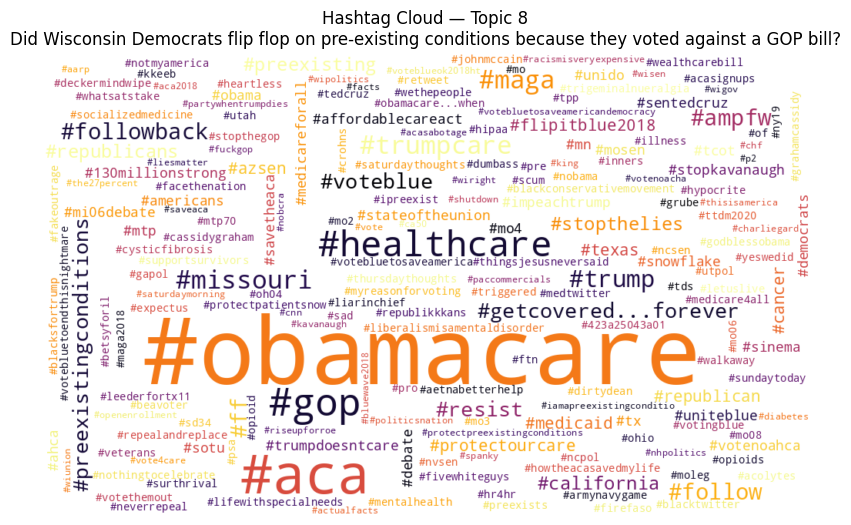

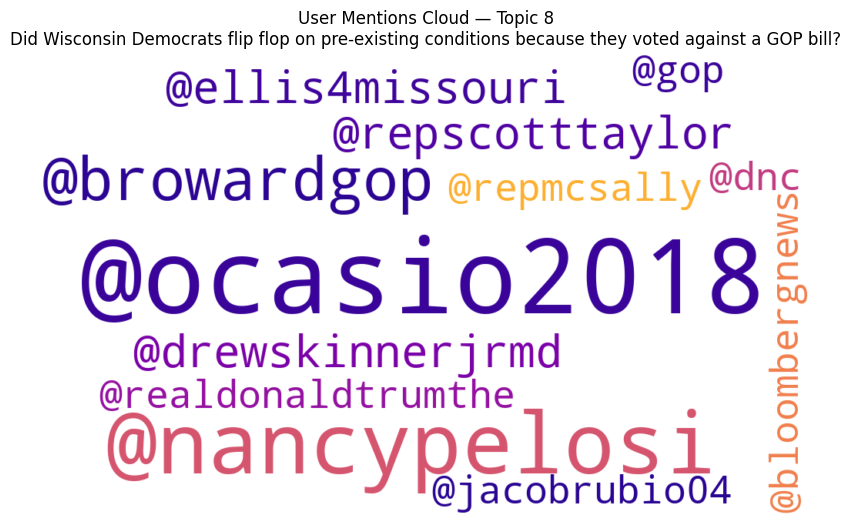

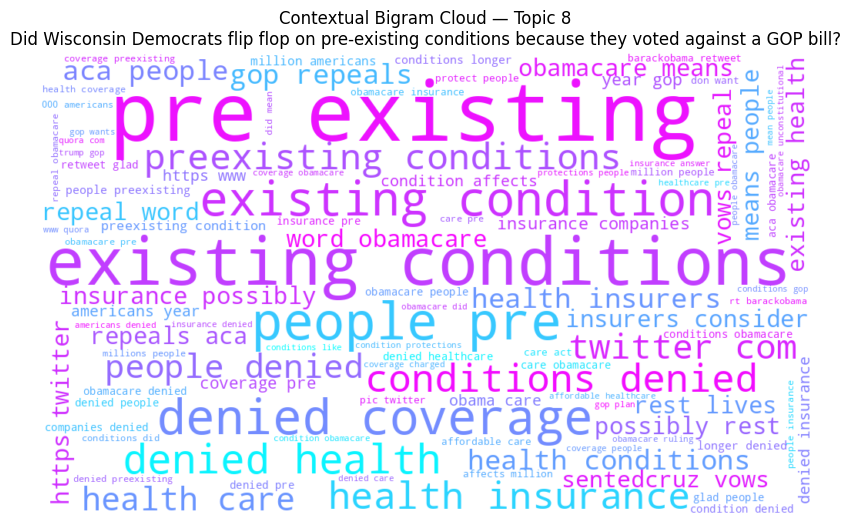


🟦 Topic 0 — Alexandria Ocasio-Cortez wrong about spending in Georgia race
 - 468 total hashtags
 - 8 total mentions
 - 100 unique bigrams in text


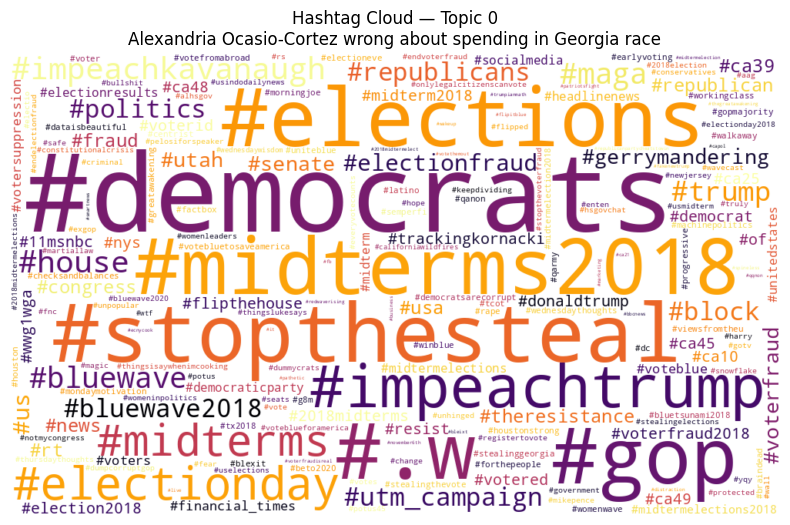

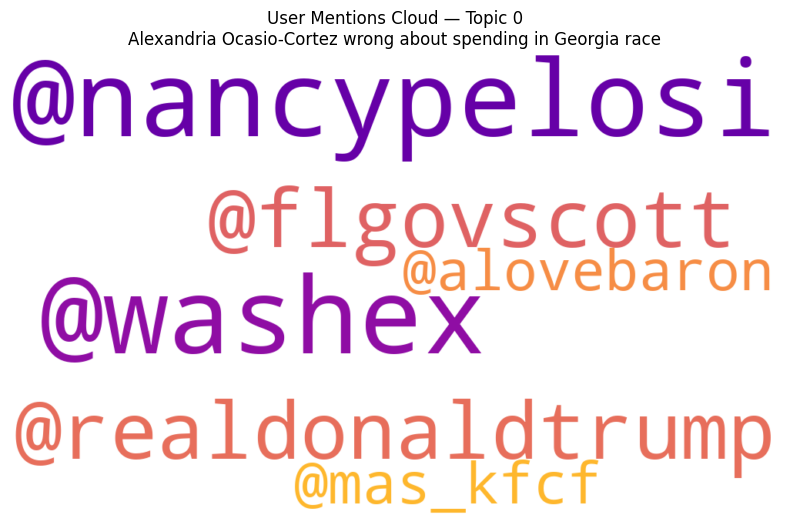

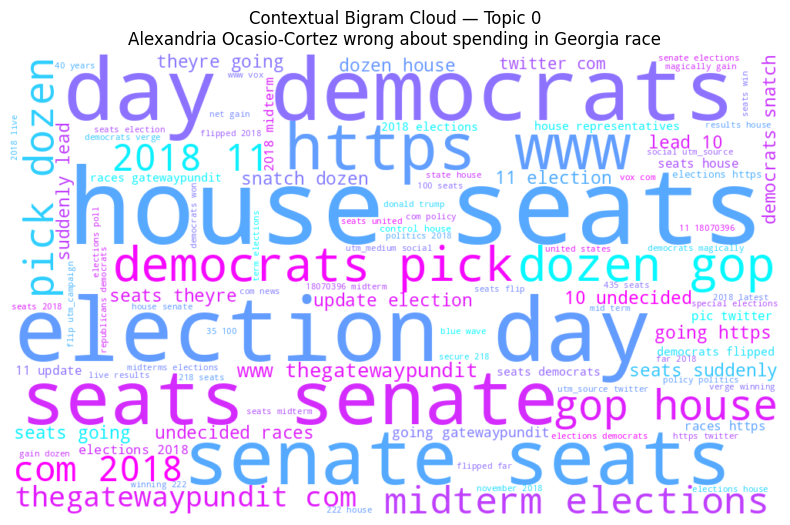


🟦 Topic 15 — Donald Trump falsely says family separations were Obama policy
 - 427 total hashtags
 - 8 total mentions
 - 100 unique bigrams in text


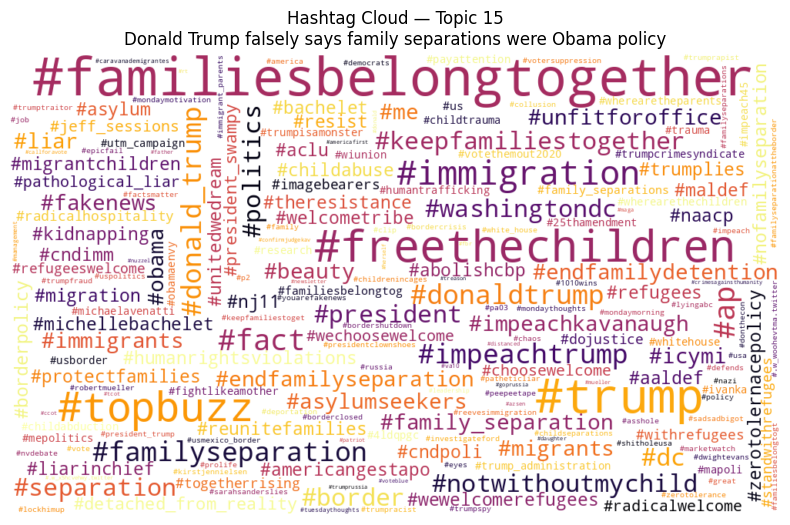

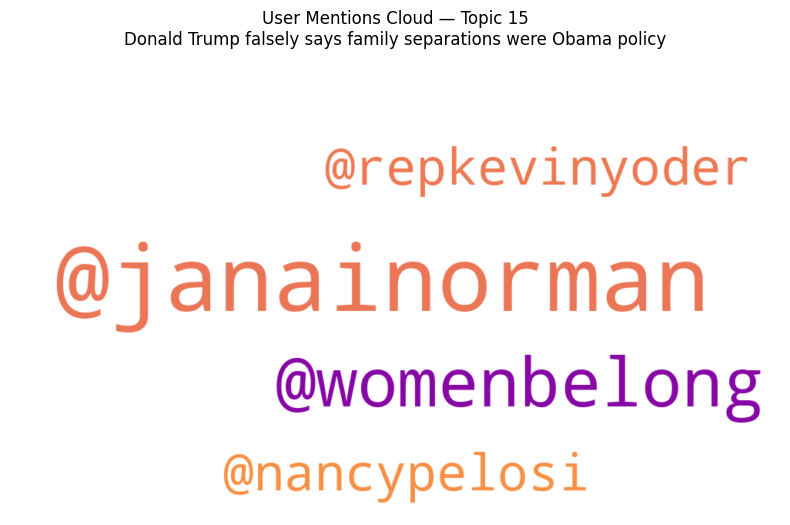

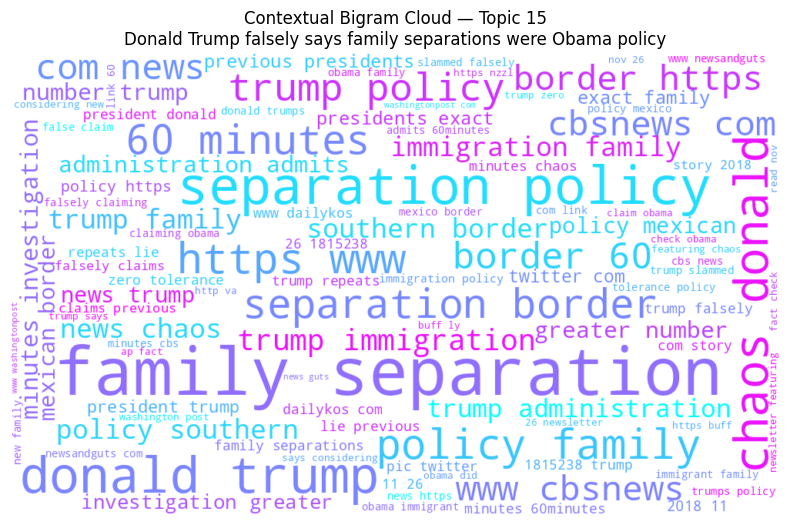


🟦 Topic 16 — Donald Trump's false claim about the cost of illegal immigration
 - 362 total hashtags
 - 8 total mentions
 - 100 unique bigrams in text


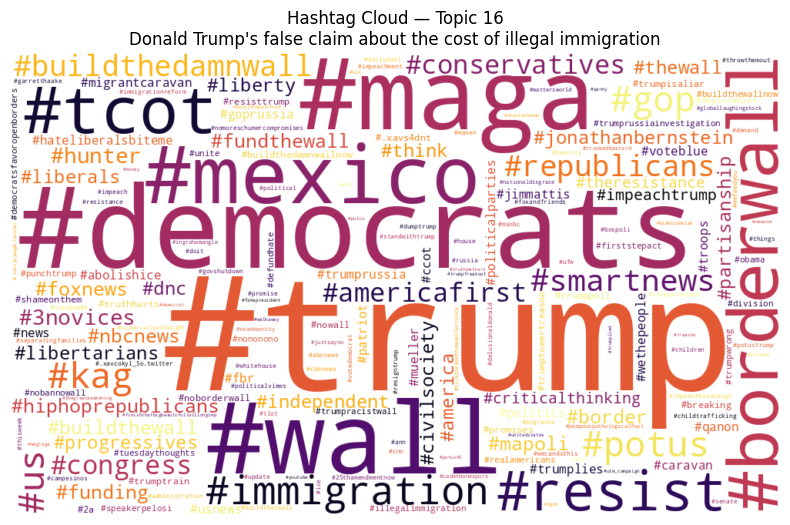

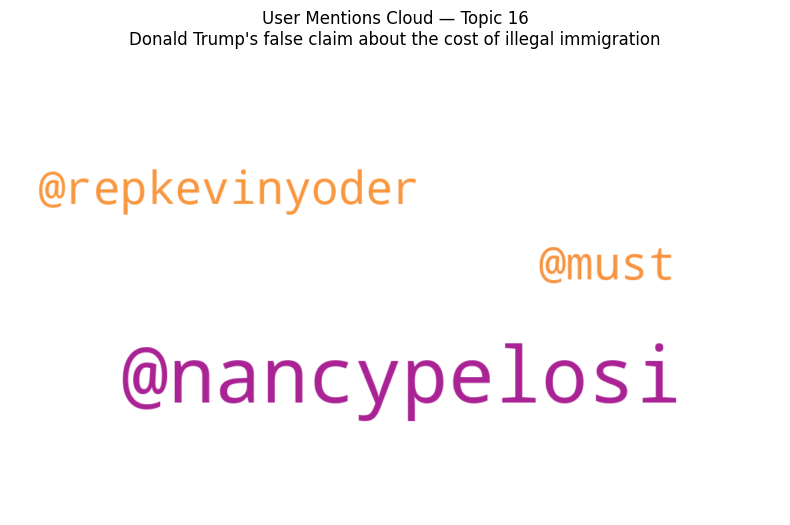

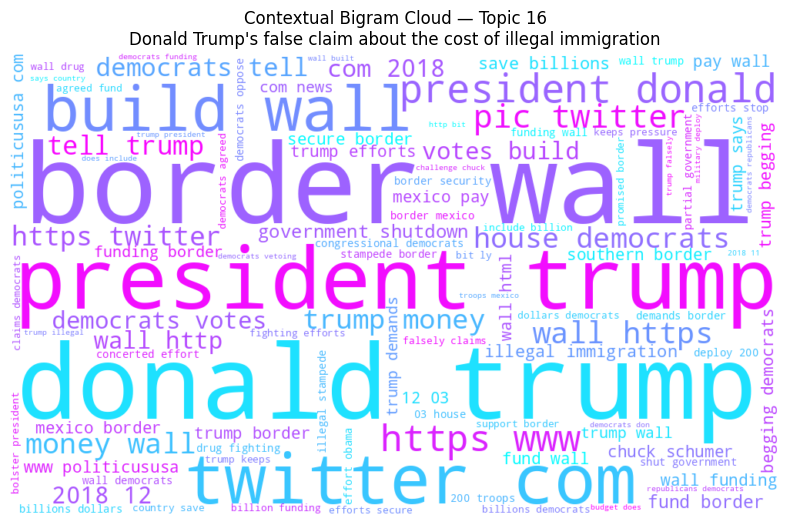


🟦 Topic 27 — No evidence Broward inmates got absentee ballots after election
 - 298 total hashtags
 - 18 total mentions
 - 100 unique bigrams in text


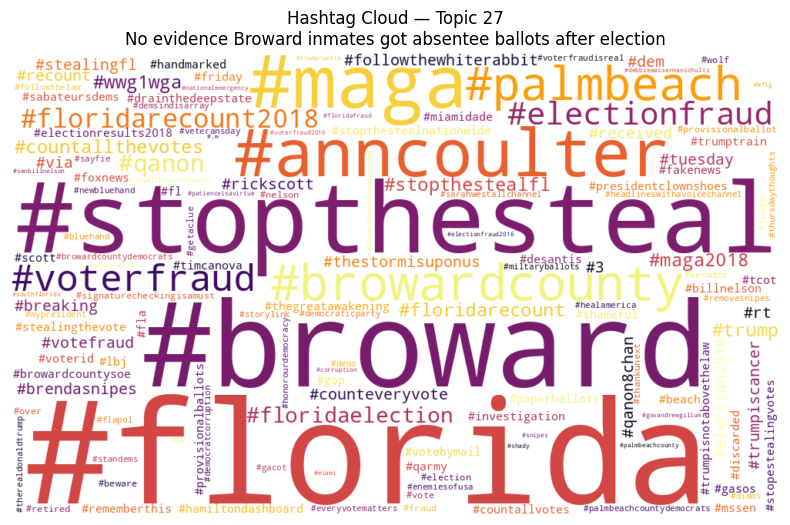

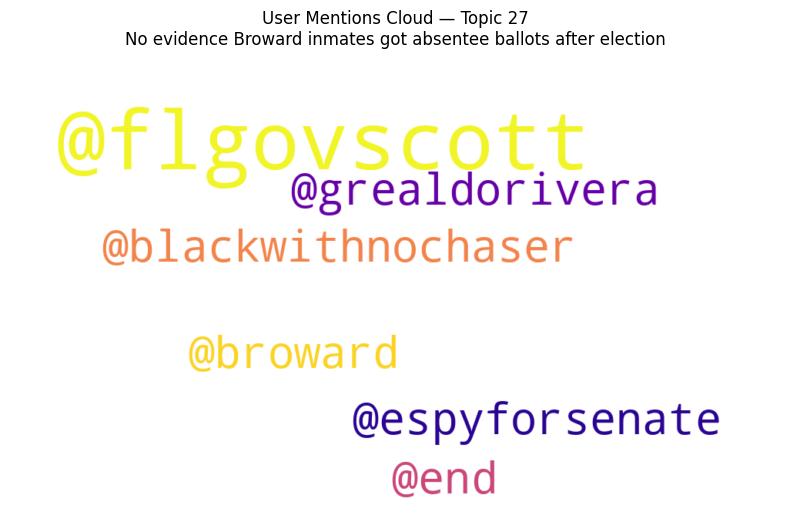

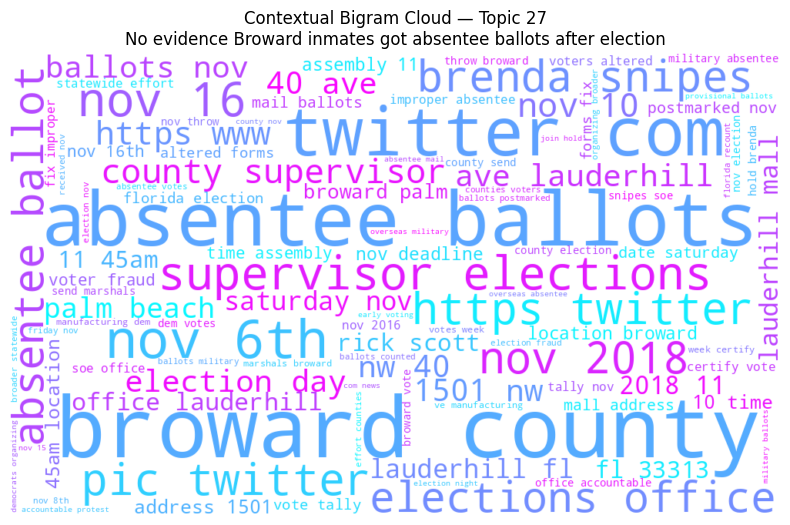

In [ ]:
import pandas as pd
import ast
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# === Assume df is already loaded ===

# --- Helper: make sure hashtag and mention columns are real lists ---
def ensure_list(cell):
    if isinstance(cell, str):
        try:
            val = ast.literal_eval(cell)
            if isinstance(val, list):
                return val
        except:
            pass
        return []
    elif isinstance(cell, list):
        return cell
    else:
        return []

df["hashtags"] = df["hashtags"].apply(ensure_list)
df["user_mentions"] = df["user_mentions"].apply(ensure_list)

# --- Identify the top 5 most frequent topics ---
top_topics = df["topic"].value_counts().head(5)
print("📊 Top 5 Topics:")
print(top_topics)
print("\n")

# --- Function to generate bigram frequencies from text ---
def get_bigram_frequencies(text_series, top_n=100):
    text_series = text_series.dropna().astype(str)
    if len(text_series) == 0:
        return {}
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words="english")
    X = vectorizer.fit_transform(text_series)
    freqs = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))
    return dict(Counter(freqs).most_common(top_n))

# --- Generate 3 word clouds (hashtags, mentions, bigrams) per topic ---
for topic_id in top_topics.index:
    topic_df = df[df["topic"] == topic_id]

    # Get the most common title for this topic (for labeling)
    title_text = topic_df["title"].dropna().unique()
    if len(title_text) > 0:
        title_text = title_text[0][:100]  # truncate long titles
    else:
        title_text = "No title available"

    # Collect all hashtags, mentions, and text
    all_hashtags = [tag.lower() for tags in topic_df["hashtags"] for tag in tags if tag]
    all_mentions = [user.lower() for mentions in topic_df["user_mentions"] for user in mentions if user]
    all_texts = topic_df["content"]

    # Count frequencies
    hashtag_counts = Counter(all_hashtags)
    mention_counts = Counter(all_mentions)
    bigram_counts = get_bigram_frequencies(all_texts)

    print(f"\n🟦 Topic {topic_id} — {title_text}")
    print(f" - {len(all_hashtags)} total hashtags")
    print(f" - {len(all_mentions)} total mentions")
    print(f" - {len(bigram_counts)} unique bigrams in text")

    # === Hashtag Word Cloud ===
    if hashtag_counts:
        wordcloud_hashtags = WordCloud(
            width=1000, height=600, background_color="white", colormap="inferno"
        ).generate_from_frequencies(hashtag_counts)

        plt.figure(figsize=(10, 6))
        plt.title(f"Hashtag Cloud — Topic {topic_id}\n{title_text}")
        plt.imshow(wordcloud_hashtags, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    else:
        print("⚠️ No hashtags for this topic.")

    # === Mentions Word Cloud ===
    if mention_counts:
        wordcloud_mentions = WordCloud(
            width=1000, height=600, background_color="white", colormap="plasma"
        ).generate_from_frequencies(mention_counts)

        plt.figure(figsize=(10, 6))
        plt.title(f"User Mentions Cloud — Topic {topic_id}\n{title_text}")
        plt.imshow(wordcloud_mentions, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    else:
        print("⚠️ No user mentions for this topic.")

    # === Bigram Word Cloud ===
    if bigram_counts:
        wordcloud_bigrams = WordCloud(
            width=1000, height=600, background_color="white", colormap="cool"
        ).generate_from_frequencies(bigram_counts)

        plt.figure(figsize=(10, 6))
        plt.title(f"Contextual Bigram Cloud — Topic {topic_id}\n{title_text}")
        plt.imshow(wordcloud_bigrams, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    else:
        print("⚠️ No textual bigrams for this topic.")


# NetworkX Graphs

Imports

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D  # for edge legend entry

## Authors Hashtags Bipartite Graph
This bipartite graph visualizes the relationship between key authors and the hashtags they used within a specific topic.

In [ ]:
def build_topic_author_hashtag_graph(df, authors_tfidf_dict, topic_id, top_percent=1):
    """
    Build bipartite graph where nodes are authors and hashtags and edges represent usage of hashtags by authors.
    Args:
        df (pd.DataFrame): DataFrame with columns 'author' (list), 'hashtags', 'topic'.
        authors_tfidf_dict (dict): Nested dict {topic: {author: tfidf_score}}.
        topic_id (int): Topic identifier.
        top_percent (float): Percentile threshold (e.g., 1 for the top 1%) — only authors with the highest TF-IDF scores within this percentile are included.
    Returns:
        networkx.Graph
    """

    title = "Key Authors and Hashtags Bipartite Graph"
    explanation = f"""Topic: {topic_id}, Threshold: {top_percent}% \n
    Blue nodes represent key authors (based on TF-IDF scores), and red nodes represent hashtags.\n
    An edge connects an author to a hashtag if the author used that hashtag in the selected topic."""
    G = nx.Graph(title = title, explanation=explanation, topic="topic_id", top_percent=top_percent)

    for _, row in df.iterrows():

        author = row['author']

        # Skip rows that do not belong
        if row['topic'] != topic_id or not is_key_author(authors_tfidf_dict, topic_id, author, top_percent):
            continue

        # Add author node
        G.add_node(author, bipartite=0, type='author', color='skyblue')
        # Add hashtags' nodes and edge btween author and usded hashtag
        for hashtag in row['hashtags']:
            G.add_node(hashtag, bipartite=1, type='hashtag', color='lightcoral')
            G.add_edge(author, hashtag)

    return G



In [ ]:
def draw_topic_author_hashtag_graph(G) :
    top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
    pos = nx.bipartite_layout(G, top_nodes)
    node_colors = [G.nodes[n]['color'] for n in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_color=node_colors, font_size=9, font_weight='bold', edge_color='gray')

    plt.title(G.graph['title'], fontsize=14, fontweight='bold')

    plt.text(0.0, -0.0, G.graph['explanation'], ha='left',va='top',transform=plt.gca().transAxes, fontsize=10,wrap=True)

    legend_elements = [
        Patch(facecolor='skyblue', edgecolor='black', label='Key Authors'),
        Patch(facecolor='lightcoral', edgecolor='black', label='Hashtags'),
        Line2D([0], [0], color='gray', lw=2, label='Hashtag Usage')
    ]
    plt.legend( handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5)

    plt.axis('off')
    plt.show()

In [ ]:
# G = build_topic_author_hashtag_graph(df, authors_tfidf_dict, topic_id=2)
# draw_topic_author_hashtag_graph(G)

## Behavioral Similarity Graph
This Behavioral Similarity Graph illustrates key authors and the hashtags they used within a specific topic.
Blue nodes represent authors, red nodes represent hashtags, and edges indicate usage.

In [ ]:
from itertools import combinations

def build_author_similarity_graph(df, authors_tfidf_dict, topic_id, top_percent=1):
    """
    Builds a graph where nodes are key-authors and edges connect authors who used at least one common hashtag.
    Args:
        df (pd.DataFrame): DataFrame with 'author' (list), 'hashtags' (list), 'topic'.
        authors_tfidf_dict (dict): {topic: {author: tfidf_score}}.
        topic_id (int): Topic to filter by.
        top_percent (float): Threshold for selecting top authors.
    Returns:
        networkx.Graph
    """

    title = "Key Author Behavioral Similarity Graph"
    topic = topic_id_to_title[topic_id]
    explanation = f"""Topic_id: {topic_id}, Topic: {topic}
                      \nKey Authors' Threshold: {top_percent}%
                      \nNode lable: author's name, tf-idf score.
                      \nEdge width represents number of shared hashtags between authors"""
    G = nx.Graph(title = title, explanation=explanation,topic_id=topic_id, topic=topic, top_percent=top_percent)

    # Build author_hashtags_dict {author: set of hashtags}
    key_author_hashtags_dict = defaultdict(set)
    for _, row in df.iterrows():

        author = row['author']

        # Filters only relevant rows.
        if row['topic'] != topic_id or not is_key_author(authors_tfidf_dict, topic_id, author, top_percent):
            continue

        key_author_hashtags_dict[author].update(row['hashtags'])

    # Add authors nodes
    for author in key_author_hashtags_dict.keys():
        G.add_node(author, score=authors_tfidf_dict[topic_id][author] ,color='skyblue')

    # Add edges between authors who share at least one hashtag
    for a1, a2 in combinations(key_author_hashtags_dict.keys(), 2):
        shared_hashtags = key_author_hashtags_dict[a1] & key_author_hashtags_dict[a2]
        if shared_hashtags:
            G.add_edge(a1, a2, weight=len(shared_hashtags))

    return G

In [ ]:
def draw_author_similarity_graph(G, minimal_edge_weight = 1) :
    filtered_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= minimal_edge_weight]
    edge_weights = [G.edges[e]['weight'] for e in filtered_edges]

    labels = {node: f"{node}\n{G.nodes[node]['score']:.4f}" for node in G.nodes()}

    nx.draw_spring(G, with_labels=True, labels=labels, node_color='skyblue', font_size=9, font_weight='bold', edge_color='gray',edgelist = filtered_edges, width = edge_weights)
    legend_elements = [
        Patch(facecolor='skyblue', edgecolor='black', label='Key Authors'),
        Line2D([0], [0], color='gray', lw=2, label='Same Hashtag Usage')
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5)
    plt.title(G.graph["title"], fontsize=14)
    plt.text(0.0, -0.0, f"\nminimal edge weight = {minimal_edge_weight}\n\n" + G.graph["explanation"]  , ha='left', va='top', transform=plt.gca().transAxes, fontsize=10, wrap=True)
    plt.axis('off')
    plt.show()

    summary_df = build_author_activity_df(df, author=G.nodes, topic_id_to_title= topic_id_to_title, topic_id = G.graph['topic_id'])
    print(tabulate(summary_df, headers='keys', tablefmt='pretty'))

In [ ]:
# G = build_author_similarity_graph(df, authors_tfidf_dict, topic_id=123)
# draw_author_similarity_graph(G, minimal_edge_weight = 1)

# Statistics

## List of Extracted Topics

In [ ]:
topic_counts_df = df['topic'].value_counts().reset_index()
topic_counts_df.columns = ['topic', 'post count']  # rename for clarity
topic_counts_df['title'] = topic_counts_df['topic'].apply(lambda x: topic_id_to_title[x])

print("Head of topic_counts_df:")
topic_counts_df.head(20)
# print(tabulate(topic_counts_df.head(), headers='keys', tablefmt='pretty'))



Head of topic_counts_df:


topic  post count   title
0      0       50000  topic0

## Topic's Top Entitie and Authors

In [ ]:
def print_entity_score_stats(dict_item_score, topic_id, entity_type, remove_zeroes = True, top_n = 10):
    """
    Prints statistics for a specific entity type in a given topic.
    Args:
        dict_item_score (dict) {topic: {entity: score}}
        topic_id (int): Topic identifier.
        entity_type (str): Entity type (e.g., 'hashtags', 'mentions').
        top_n (int): The number of top items to present.
        remove_zeroes (bool): If true, removes items with a score of 0.
    """
    scores = list(dict_item_score[topic_id].values())
    if not scores:
        print(f"No scores found for {entity_type}")
        return
    print(f"--- Stats for Topic Id: {topic_id}, Entity Type: {entity_type} ---")
    print(f"Topic: {topic_id_to_title[topic_id]}")
    print(f"Min: {np.min(scores):.4f}")
    print(f"Max: {np.max(scores):.4f}")
    print(f"Mean: {np.mean(scores):.4f}")
    print(f"Std: {np.std(scores):.4f}")
    print(f"Median: {np.median(scores):.4f}")

    sorted_entities_by_scores = (sorted(dict_item_score[topic_id].items(), key=lambda x: x[1], reverse=True))[:top_n]
    if remove_zeroes:
        sorted_entities_by_scores = [(entity, score) for entity, score in sorted_entities_by_scores if score > 0]

    print(f"Top {top_n} {entity_type}:")
    for entity, score in sorted_entities_by_scores:
        print(f"\t \t {entity:<15} Score: {score:.4f}")
    print()


print_entity_score_stats(hashtags_tfidf_dict, topic_id=0, entity_type="Hashtags")
print_entity_score_stats(mention_tfidf_dict, topic_id=0, entity_type="Mentions")
print_entity_score_stats(authors_tfidf_dict, topic_id=0, entity_type="Authors")
# new entity dict's structure: {topic: {entity: tfidf_score}}
# old entity dict's structure: {(topic, entity): tfidf_score}

No scores found for Hashtags
No scores found for Mentions
No scores found for Authors


In [ ]:
hashtags_tfidf_dict

defaultdict(<function __main__.compute_entity_tfidf_scores.<locals>.<lambda>()>,
            {'0': defaultdict(float,
                         {'soybomberovoluntario': np.float64(2.032726903140563e-05),
                          'Gye': np.float64(0.0018091269437951012),
                          'u2': np.float64(2.032726903140563e-05),
                          'Uio': np.float64(0.0018904360199207236),
                          'preguntasdetwitter': np.float64(4.065453806281126e-05),
                          'PuertoLimpio': np.float64(4.065453806281126e-05),
                          'VivimosEnUnPaísDonde': np.float64(2.032726903140563e-05),
                          'PreguntasDeTwitter': np.float64(0.0001422908832198394),
                          'Quito': np.float64(0.058461225734322594),
                          'Câncer': np.float64(0.002195345055391808),
                          'FollowSOALKU': np.float64(2.032726903140563e-05),
                          'hadeh': np.float64(2.03

## Topic Entities Report

In [ ]:
import random
import heapq
import pandas as pd
import urllib.parse


def top_from_dict(d: dict, num_entities: int):
    """Return the top `num_entities` (entity, score) pairs from a dict."""
    return heapq.nlargest(num_entities, d.items(), key=lambda x: x[1])


def get_context_for_entity(entity: str, df_topic: pd.DataFrame, context_window: int = 10):
    """
    Return between 5 and 10 context texts (tweets) for a given entity.
    - If entity starts with "@", search in user_mentions column.
    - If entity starts with "#", search in hashtags column.
    - Otherwise, search in content column.
    """
    if entity.startswith("@"):
        matches = df_topic[df_topic["user_mentions"].apply(
            lambda mentions: entity in mentions if isinstance(mentions, list) else False
        )]
    elif entity.startswith("#"):
        matches = df_topic[df_topic["hashtags"].apply(
            lambda tags: entity in tags if isinstance(tags, list) else False
        )]
    else:
        matches = df_topic[df_topic["content"].str.contains(entity, case=False, na=False)]

    all_contexts = matches["content"].tolist()
    if not all_contexts:
        return []

    # Choose a random number between 5 and 10 (but not more than available)
    k = min(random.randint(5, 10), len(all_contexts))
    return random.sample(all_contexts, k)

def build_twitter_link(entity: str) -> str:
    """Return an X (Twitter) search link for the entity."""
    base_url = "https://x.com/search?q="
    if entity.startswith("@"):
        # User mention: encode '@' and add &f=top for top results
        query = urllib.parse.quote(entity)
        return f"{base_url}{query}&src=typed_query&f=top"
    elif entity.startswith("#"):
        # Hashtag: encode '#' and add &f=top for top results
        query = urllib.parse.quote(entity)
        return f"{base_url}{query}&src=typed_query&f=top"
    else:
        # General text search: no &f=top
        query = urllib.parse.quote(entity)
        return f"{base_url}{query}&src=typed_query"

def entities_report(
    df,
    tfidf_scores_dict: dict,
    tf_scores_dict: dict,
    topic_id: int,
    num_entities: int = 20,
    context_window: int = 10
) -> pd.DataFrame:
    """
    Build a report DataFrame with selected entities for a given topic:
      - Top entities by TF-IDF
      - Top entities by TF
      - Random entities from the remaining pool

    Adds:
      - tf-idf score
      - tf score (only for TF-selected entities)
      - flag for TF-IDF-selected entities
      - context list of up to `context_window` texts from df
      - topic metadata (title, description, url_right)
    """
    # Get scores for the current topic
    topic_tfidf_scores = tfidf_scores_dict[topic_id]
    topic_tf_scores = tf_scores_dict[topic_id]

    # Preselect more entities to ensure uniqueness
    top_tfidf_entities = top_from_dict(topic_tfidf_scores, num_entities * 2)
    top_tf_entities = top_from_dict(topic_tf_scores, num_entities * 2)

    # Preprations
    selected_entities = set()
    tf_selected = set()
    tfidf_selected = set()

    # Add top TF-IDF entities
    for e, _ in top_tfidf_entities:
        selected_entities.add(e) # this is a set so no duplication
        tfidf_selected.add(e)
        if len(selected_entities) >= num_entities:
            break

    # Add top TF entities
    for e, _ in top_tf_entities:
        selected_entities.add(e)
        tf_selected.add(e)
        if len(selected_entities) >= num_entities * 2:
            break

    # Add random entities until reaching num_entities*3
    remaining_entities = set(topic_tfidf_scores.keys()) - selected_entities
    remaining_entities_num = min(num_entities * 3 - len(selected_entities), len(remaining_entities))
    selected_entities.update(random.sample(list(remaining_entities), remaining_entities_num))

    # Build DataFrame
    entities_report_df = pd.DataFrame(selected_entities, columns=["entity"])

    entities_report_df["tf-idf score"] = entities_report_df["entity"].apply(lambda e: topic_tfidf_scores.get(e, 0.0))
    entities_report_df["tf score"] = entities_report_df["entity"].apply(lambda e: topic_tf_scores[e])
    entities_report_df["is_top_tfidf"] = entities_report_df["entity"].apply(lambda e: e in tfidf_selected) # Was selected as top tfidf entitie
    entities_report_df["is_top_tf"] = entities_report_df["entity"].apply(lambda e: e in tf_selected) # Was selected as top tf entitie

    # Add context
    topic_rows = df[df["topic"] == topic_id]
    entities_report_df["context"] = entities_report_df["entity"].apply(lambda e: get_context_for_entity(e, topic_rows, context_window))

    # Add topic metadata
    topic_row = topic_rows.iloc[0]
    entities_report_df["topic"] = topic_row.title
    entities_report_df["description"] = topic_row.description
    entities_report_df["twitter_link"] = entities_report_df["entity"].apply(build_twitter_link)
    entities_report_df["url"] = topic_row.url_right
    entities_report_df["human score 1-3"] = None

    # Shuffle rows
    entities_report_df = entities_report_df.sample(frac=1).reset_index(drop=True)
    return entities_report_df


In [ ]:
topic_id = 0
# 5 8 16 10 18
mentions_report = entities_report(df,mention_tfidf_dict, tf_mentions, topic_id)
hastags_report =  entities_report(df,hashtags_tfidf_dict, tf_hashtags, topic_id)

print(f"For topic id {topic_id}")
print(f"mentions_report shape: {mentions_report.shape}")
print(f"hastags_report shape: {hastags_report.shape}")

# seleected_topics = [31, 90]

For topic id 0
mentions_report shape: (60, 11)
hastags_report shape: (60, 11)


In [ ]:
# Save mentions report
mentions_report.to_excel(f"topic_{topic_id}_mentions_report.xlsx", index=False)
files.download(f"topic_{topic_id}_mentions_report.xlsx")

# Save hashtags report
hastags_report.to_excel(f"topic_{topic_id}_hastags_report.xlsx", index=False)
files.download(f"topic_{topic_id}_hastags_report.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Topic Eentities Usage

In [ ]:
def topic_entities_usage(df, topic_id, entity_col_name):
    """
    Returns entities and their usage and frequency for a given topic. Frequency is rounded to 3 decimal places.
    Args:
        df (pd.DataFrame): DataFrame with posts.
        topic_id (int or str): Topic to filter.
        entity_col_name (str): Column name with a list of entities (e.g., 'hashtags', 'user_mentions').
    Returns:
        pd.DataFrame: A DataFrame with columns [entity, count, percent].
    """
    topic_df = df[df['topic'] == topic_id]

    total_posts_num = len(topic_df)

    # Explode entity list into individual rows, drop nulls, and count occurrences
    entities_freq = topic_df[entity_col_name].explode().dropna().value_counts()

    # Convert Series to DataFrame
    entities_freq_df = entities_freq.reset_index()
    entities_freq_df.columns = [entity_col_name, 'count']

    # Calculate percentage and add as a new column
    entities_freq_df['percent'] = round((entities_freq_df['count'] / total_posts_num) * 100, 3)

    return entities_freq_df


In [ ]:
topic_entities_usage(df, topic_id=5, entity_col_name="hashtags").head(10)

Empty DataFrame
Columns: [hashtags, count, percent]
Index: []

## Topic's Top Posts

In [ ]:
def find_topic_top_posts(df, topic_id, score_col_name="post_topic_tfidf", top_n=5):
    """
    Prints the top N posts for a given topic ID.
    Args:
        df (pd.DataFrame): DataFrame with at least 'topic_id' and 'title' columns.
        topic_id (int or str): The topic ID to filter by.
        top_n (int): Number of top posts to display.
        score_col_name (str or None): Column name of posts' scores.
    """
    topic_df = df[df['topic'] == topic_id]
    topic_df = topic_df[['topic', 'title', 'author', 'content', 'post_topic_tfidf', 'date', 'author_score', 'c_post_id']]
    if topic_df.empty:
        print(f"No posts found for topic {topic_id}")
        return


    top_posts = topic_df.sort_values(by=score_col_name, ascending=False).head(top_n)
    return top_posts


topic_top_post_df = find_topic_top_posts(df, topic_id=123)
topic_top_post_df
print(tabulate(topic_top_post_df, headers='keys', tablefmt='grid', stralign='left'))

KeyError: "['post_topic_tfidf', 'author_score'] not in index"

# Neo4j Graphs

[Information_Flow_Graph_Design.md](https://github.com/NoaTal1996/Backbone-Graph/blob/main/docs/Information_Flow_Graph_Design.md)

## Imports and Preparations

In [ ]:
!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.8/325.8 kB 7.3 MB/s eta 0:00:00


In [ ]:
from getpass import getpass
from neo4j import GraphDatabase
import json

In [ ]:
"""
# Access variable via user input
uri = input("Enter Neo4j URI (e.g. neo4j+s://xxxx.databases.neo4j.io")
username = input("Enter Neo4j username: ")
password = getpass("Enter Neo4j password: ")
"""

'\n# Access variable via user input\nuri = input("Enter Neo4j URI (e.g. neo4j+s://xxxx.databases.neo4j.io")\nusername = input("Enter Neo4j username: ")\npassword = getpass("Enter Neo4j password: ")\n'

In [ ]:
# Access variable from google colab secrets
from google.colab import userdata

neo4j_driver = GraphDatabase.driver(userdata.get('NEO4J_URI'), auth=(userdata.get('NEO4J_USERNAME'), userdata.get('NEO4J_PASSWORD')))
neo4j_driver.verify_connectivity()
# Note: BGU wifi blocks the rellevent port.

ServiceUnavailable: Failed to DNS resolve address 25d861a4.databases.neo4j.io:7687: [Errno -2] Name or service not known

## Add Graph Elements

In [ ]:
def neo4j_add_node_from_dict(driver, label: str, properties: dict, unique_key: str):
    """
    Create or update a Neo4j node from a dictionary.
    Args:
        driver: Neo4j driver instance.
        label (str): Node label (e.g. "Author").
        properties (dict): Node properties.
        unique_key (str): Field used to uniquely identify the node.
    """
    key_value = properties[unique_key]

    # https://neo4j.com/docs/cypher-cheat-sheet/5/all
    query = f"""
    MERGE (n:{label} {{{unique_key}: $key_value}})
    SET n = $properties
    """

    with driver.session() as session:
        session.run(query, key_value=key_value, properties=properties)


In [ ]:
def neo4j_add_link_from_dict(
    neo4j_driver,
    node_label_1,
    match_key_1, node_value_1,
    node_label_2,
    match_key_2, node_value_2,
    rel_type: str,
    rel_properties: dict
):
    """
    Creates or updates a relationship with properties between two nodes with dynamic labels and dynamic match keys.

    Args:
        neo4j_driver: Neo4j driver instance.
        node_label_1 (str): Label of the source node.
        match_key_1 (str): Property key to match source node (e.g., 'username').
        node_value_1 (str): Value to match for source node.
        node_label_2 (str): Label of the target node.
        match_key_2 (str): Property key to match target node (e.g., 'username').
        node_value_2 (str): Value to match for target node.
        rel_type (str): Type of the relationship (e.g., 'MENTIONS').
        rel_properties (dict): Properties to set on the relationship.
    """
    query = f"""
    MATCH (a:{node_label_1} {{{match_key_1}: $node_value_1}}),
          (b:{node_label_2} {{{match_key_2}: $node_value_2}})
    MERGE (a)-[r:{rel_type}]->(b)
    SET r += $rel_properties
    """

    parameters = {
        "node_value_1": node_value_1,
        "node_value_2": node_value_2,
        "rel_properties": rel_properties
    }

    with neo4j_driver.session() as session:
        session.run(query, parameters)


## Clear Graph

In [ ]:
def clear_neo4j_graph(neo4j_driver):
    """
    Deletes all nodes and relationships from the Neo4j graph.
    WARNING: This is irreversible and will wipe the database clean.
    """
    query = "MATCH (n) DETACH DELETE n"
    with neo4j_driver.session() as session:
        session.run(query)


## Build Graph

In [ ]:
def build_neo4j_graph(df, topic_id, authors_tfidf_dict, topic_id_to_title, neo4j_driver, min_time = 1, max_time = 5, entities_min_threshold = 2, top_n = 5, key_authosr_top_percent=1 ):
    """
    build neo4j graph as decribed at https://github.com/NoaTal1996/Backbone-Graph/blob/main/docs/Information_Flow_Graph_Design.md
    Args:
        df (pd.DataFrame): DataFrame with columns ['author', 'topic', 'post_topic_tfidf', 'hashtags', 'user_mentions'].
        topic_id (int): Topic to filter by.
        authors_tfidf_dict (dict): {topic: {author: tfidf_score}}.
        topic_id_to_title (dict): {topic_id: topic_title}
        neo4j_driver: the neo4j driver
        min_time (int): the minimal time of enteity use in days.
        max_time (int): the maximal time of enteity use in days.
        entities_min_threshold (percent): the threshold for entities in %.
        top_n (int): Number of top entities\topics to be presented.
        key_authosr_top_percent (float): Percentile threshold (e.g., 1 for top 1%).
    Returns:
        None
    """
    # Find key authosr: {author: score}
    authors = find_topic_key_authors(authors_tfidf_dict, topic_id, key_authosr_top_percent).keys()

    # authors' activity: Lst({property: value})
    key_authors_activity = build_author_activity_dict(df, authors, topic_id_to_title, top_n, topic_id)

    # add auters as noeds
    for author_activity in key_authors_activity:
      neo4j_add_node_from_dict(driver=neo4j_driver, label="Author", unique_key="username", properties=author_activity)


    # Calculate global entity frequencies (hashtags + mentions)
    hashtag_freq = topic_entities_freq(df, topic_id, "hashtags")
    mention_freq = topic_entities_freq(df, topic_id, "user_mentions")

    # Creat dict {autor : {entity : date of first time use}}
    author_hashtag_date_dict = defaultdict(lambda: defaultdict(lambda: np.datetime64('9999-12-31')))
    author_mention_date_dict = defaultdict(lambda: defaultdict(lambda: np.datetime64('9999-12-31')))

    filtered_df = df[(df['topic'] == topic_id) & (df['author'].isin(authors))]
    for _, row in filtered_df.iterrows():
        author = row['author']
        hashtags = row['hashtags']
        mentions = row['user_mentions']
        date = row['date']

        for hashtag in hashtags:
            # Skip if entity is too common
            if hashtag_freq[hashtag] >= entities_min_threshold:
                continue
            author_hashtag_date_dict[author][hashtag] = min(author_hashtag_date_dict[author][hashtag], date)

        for mention in mentions:
            # Skip if entity is too common
            if mention_freq[mention] >= entities_min_threshold:
                continue
            author_mention_date_dict[author][mention] = min(author_mention_date_dict[author][mention], date)

    # Add an edge from Author A → Author B if B used at least one entity after Author A in the time window.
        for a in authors:
          for b in authors:
            if a == b:
                continue  # skip self-links

            shared_hashtags = []
            shared_mentions = []

            # Hashtags
            for entity in set(author_hashtag_date_dict[a].keys()).intersection(author_hashtag_date_dict[b].keys()):
                time_diff = (author_hashtag_date_dict[b][entity] - author_hashtag_date_dict[a][entity]).days
                if min_time <= time_diff <= max_time:
                    shared_hashtags.append(entity)

            # Mentions
            for entity in set(author_mention_date_dict[a].keys()).intersection(author_mention_date_dict[b].keys()):
                time_diff = (author_mention_date_dict[b][entity] - author_mention_date_dict[a][entity]).days
                if min_time <= time_diff <= max_time:
                    shared_mentions.append(entity)

            # Total unique shared entities
            shared_entity_count = len(shared_hashtags) + len(shared_mentions)

            # Add to Graph
            if shared_entity_count > 0:
                edge_properties = {
                    "shared_entity_count": shared_entity_count,
                    "shared_hashtags": shared_hashtags,
                    "shared_mentions": shared_mentions
                }

                neo4j_add_link_from_dict(
                    neo4j_driver,
                    node_label_1="Author", match_key_1="username", node_value_1=a,
                    node_label_2="Author", match_key_2="username", node_value_2=b,
                    rel_type="INFLUENCES",
                    rel_properties=edge_properties
                )


In [ ]:
clear_neo4j_graph(neo4j_driver)
build_neo4j_graph(df, 123, authors_tfidf_dict, topic_id_to_title, neo4j_driver, entities_min_threshold = 1)

In [ ]:
# topic_entities_usage(df, topic_id=123, entity_col_name="hashtags").head(10)

## Export Graph

In [ ]:
def get_graph_as_csv(neo4j_driver):
    query = """
    CALL apoc.export.csv.all(null, {stream:true, useTypes:true}) YIELD data
    RETURN data
    """
    with neo4j_driver.session() as session:
        result = session.run(query)
        return result.single()["data"]  # CSV string

In [ ]:
def get_graph_as_json(neo4j_driver):
    query = """
    CALL apoc.export.json.all(null, {stream:true, useTypes:true}) YIELD data
    RETURN data
    """
    with neo4j_driver.session() as session:
        result = session.run(query)
        return result.single()["data"]  # JSON string

In [ ]:
# print(get_graph_as_json(neo4j_driver))

# Scores Histograms

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_nested_dict_values(nested_dict):
    """
    Return all values from a nested dict.
    Args:
        nested_dict (dict): Nested dict {topic: {entity: score}}.
    Returns:
        values (list): All values of a nested dict
    """
    values = []
    for flat_dict in nested_dict.values():
        values.extend(flat_dict.values())
    return values

## TF Histogram

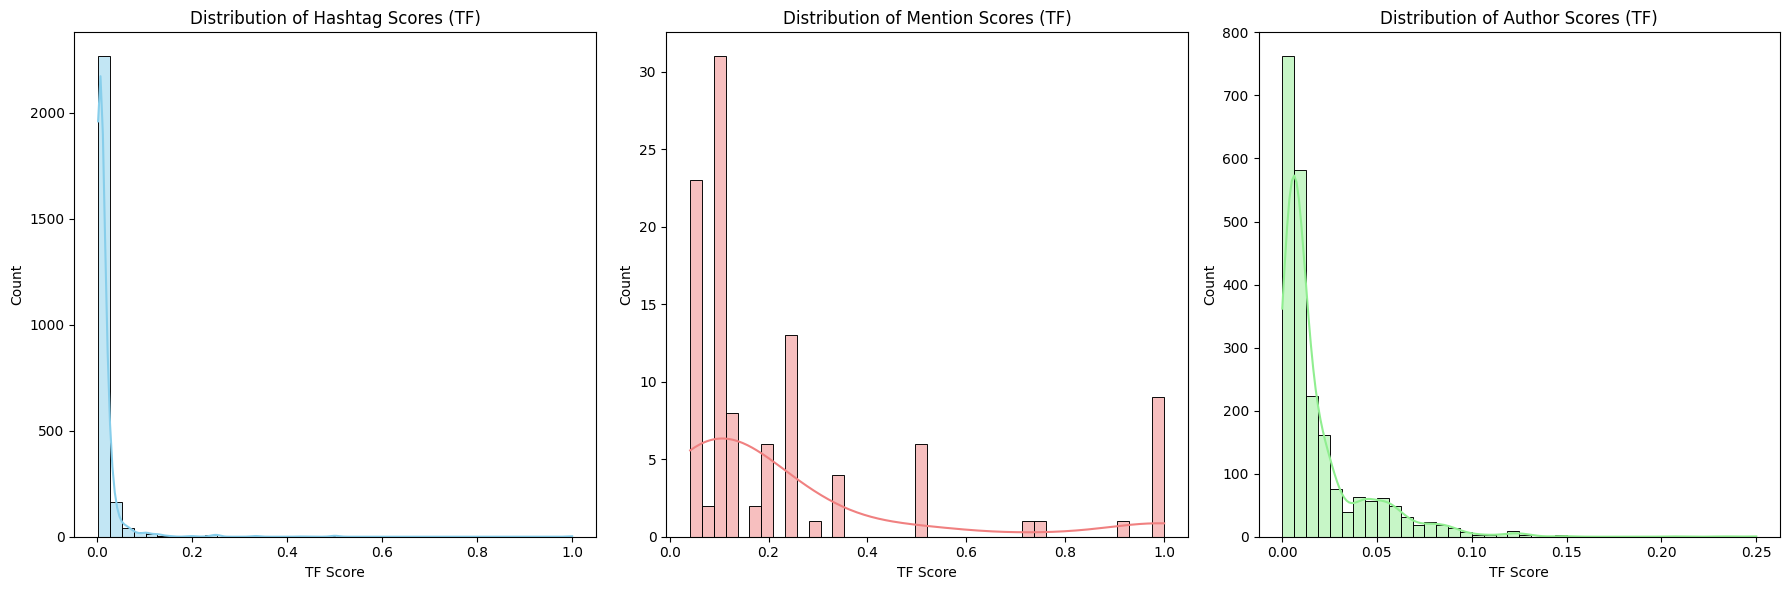

In [ ]:
# --- Collecting Scores ---

tf_hashtag_scores = get_nested_dict_values(tf_hashtags)
tf_mention_scores = get_nested_dict_values(tf_mentions)
tf_author_scores = get_nested_dict_values(tf_author)

# --- Plotting the Histograms ---

plt.figure(figsize=(18, 6)) # Set the overall figure size

# Histogram for Hashtag Scores
plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
if tf_hashtag_scores:
    sns.histplot(tf_hashtag_scores, kde=True, bins=40, color='skyblue')
    plt.title('Distribution of Hashtag Scores (TF)')
    plt.xlabel('TF Score')
    plt.ylabel('Count')
    # plt.yscale('log')
    # plt.xscale('log')
else:
    plt.text(0.5, 0.5, 'No Hashtag Scores to display', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

# Histogram for Mention Scores
plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
if tf_mention_scores:
    sns.histplot(tf_mention_scores, kde=True, bins=40, color='lightcoral')
    plt.title('Distribution of Mention Scores (TF)')
    plt.xlabel('TF Score')
    plt.ylabel('Count')
    # plt.yscale('log')
    # plt.xscale('log')
else:
    plt.text(0.5, 0.5, 'No Mention Scores to display', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

# Histogram for Author Scores
plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
if tf_author_scores:
    sns.histplot(tf_author_scores, kde=True, bins=40, color='lightgreen')
    plt.title('Distribution of Author Scores (TF)')
    plt.xlabel('TF Score')
    plt.ylabel('Count')
    # plt.yscale('log')
    # plt.xscale('log')
else:
    plt.text(0.5, 0.5, 'No Author Scores to display', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.tight_layout()
plt.show()

## DF Histogram

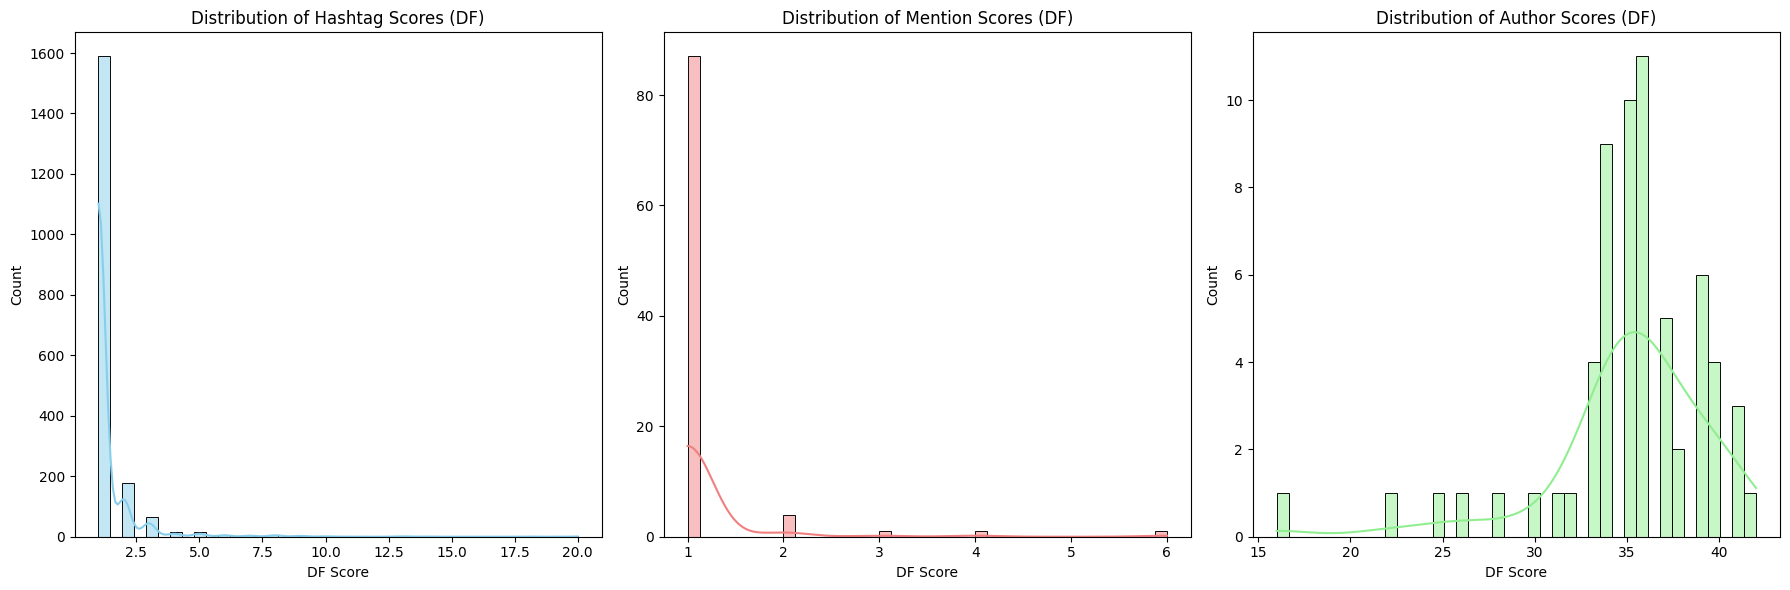

In [ ]:
# --- Collecting Scores ---

df_hashtag_scores = list(df_hashtags.values())
df_mention_scores = list(df_mentions.values())
df_author_scores  = list(df_author.values())

# --- Plotting the Histograms ---

plt.figure(figsize=(18, 6)) # Set the overall figure size

# Histogram for Hashtag Scores
plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
if df_hashtag_scores:
    sns.histplot(df_hashtag_scores, kde=True, bins=40, color='skyblue')
    plt.title('Distribution of Hashtag Scores (DF)')
    plt.xlabel('DF Score')
    plt.ylabel('Count')
    # plt.yscale('log')
    # plt.xscale('log')
else:
    plt.text(0.5, 0.5, 'No Hashtag Scores to display', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

# Histogram for Mention Scores
plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
if df_mention_scores:
    sns.histplot(df_mention_scores, kde=True, bins=40, color='lightcoral')
    plt.title('Distribution of Mention Scores (DF)')
    plt.xlabel('DF Score')
    plt.ylabel('Count')
    # plt.yscale('log')
    # plt.xscale('log')
else:
    plt.text(0.5, 0.5, 'No Mention Scores to display', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

# Histogram for Author Scores
plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
if df_author_scores:
    sns.histplot(df_author_scores, kde=True, bins=40, color='lightgreen')
    plt.title('Distribution of Author Scores (DF)')
    plt.xlabel('DF Score')
    plt.ylabel('Count')
    # plt.yscale('log')
    # plt.xscale('log')
else:
    plt.text(0.5, 0.5, 'No Author Scores to display', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.tight_layout()
plt.show()

## IDF Histogram

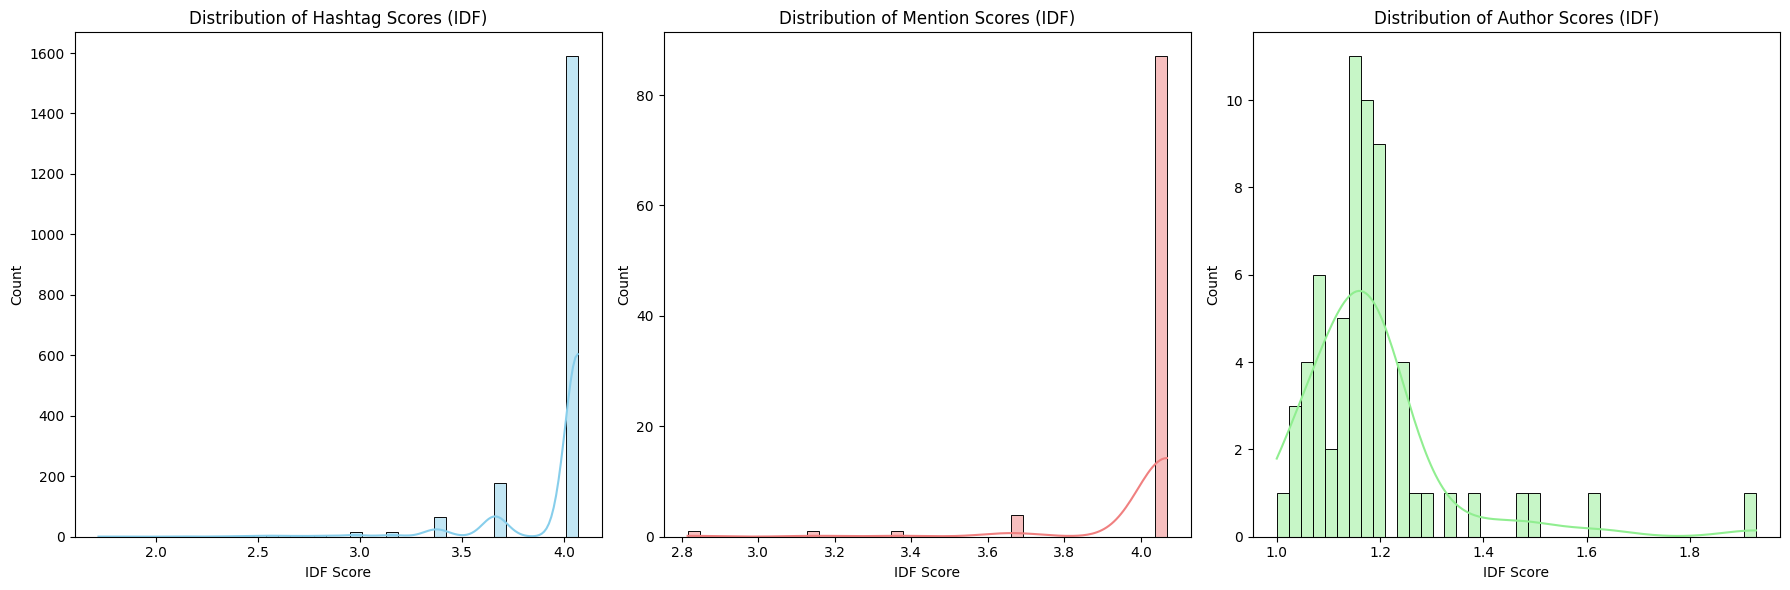

In [ ]:
# --- Collecting Scores ---

idf_hashtag_scores = list(idf_hashtags.values())
idf_mention_scores = list(idf_mentions.values())
idf_author_scores  = list(idf_author.values())

# --- Plotting the Histograms ---

plt.figure(figsize=(18, 6)) # Set the overall figure size

# Histogram for Hashtag Scores
plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
if idf_hashtag_scores:
    sns.histplot(idf_hashtag_scores, kde=True, bins=40, color='skyblue')
    plt.title('Distribution of Hashtag Scores (IDF)')
    plt.xlabel('IDF Score')
    plt.ylabel('Count')
    # plt.yscale('log')
    # plt.xscale('log')
else:
    plt.text(0.5, 0.5, 'No Hashtag Scores to display', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

# Histogram for Mention Scores
plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
if idf_mention_scores:
    sns.histplot(idf_mention_scores, kde=True, bins=40, color='lightcoral')
    plt.title('Distribution of Mention Scores (IDF)')
    plt.xlabel('IDF Score')
    plt.ylabel('Count')
    # plt.yscale('log')
    # plt.xscale('log')
else:
    plt.text(0.5, 0.5, 'No Mention Scores to display', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

# Histogram for Author Scores
plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
if idf_author_scores:
    sns.histplot(idf_author_scores, kde=True, bins=40, color='lightgreen')
    plt.title('Distribution of Author Scores (IDF)')
    plt.xlabel('IDF Score')
    plt.ylabel('Count')
    # plt.yscale('log')
    # plt.xscale('log')
else:
    plt.text(0.5, 0.5, 'No Author Scores to display', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.tight_layout()
plt.show()

## TF-IDF Histogram

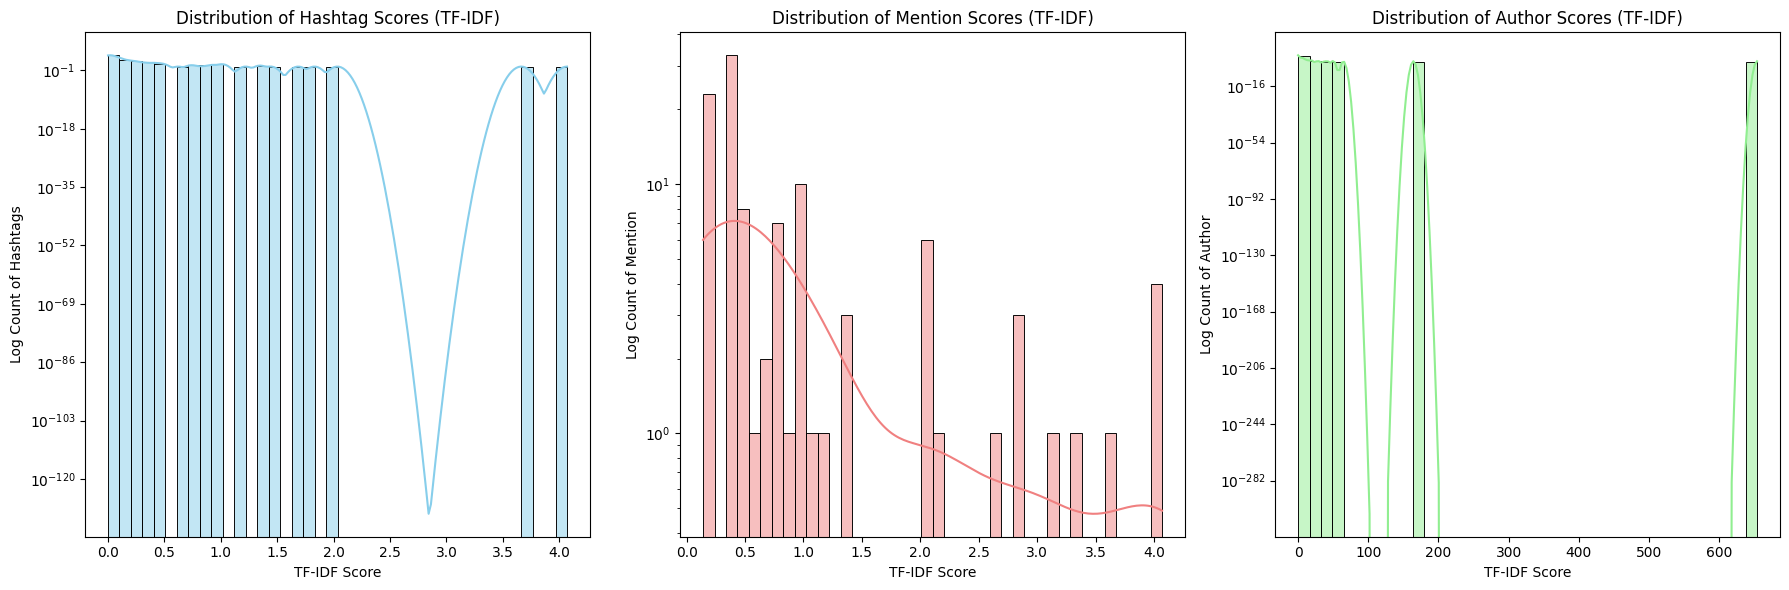

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Collecting Scores ---

all_hashtag_scores = get_nested_dict_values(hashtags_tfidf_dict)
all_mention_scores = get_nested_dict_values(mention_tfidf_dict)
all_author_scores = get_nested_dict_values(authors_tfidf_dict)

# --- Plotting the Histograms ---

plt.figure(figsize=(18, 6)) # Set the overall figure size

# Histogram for Hashtag Scores
plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
if all_hashtag_scores:
    sns.histplot(all_hashtag_scores, kde=True, bins=40, color='skyblue')
    plt.title('Distribution of Hashtag Scores (TF-IDF)')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Log Count of Hashtags')
    plt.yscale('log')
    # plt.xscale('log')
else:
    plt.text(0.5, 0.5, 'No Hashtag Scores to display', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

# Histogram for Mention Scores
plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
if all_mention_scores:
    sns.histplot(all_mention_scores, kde=True, bins=40, color='lightcoral')
    plt.title('Distribution of Mention Scores (TF-IDF)')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Log Count of Mention')
    plt.yscale('log')
    # plt.xscale('log')
else:
    plt.text(0.5, 0.5, 'No Mention Scores to display', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

# Histogram for Author Scores
plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
if all_author_scores:
    sns.histplot(all_author_scores, kde=True, bins=40, color='lightgreen')
    plt.title('Distribution of Author Scores (TF-IDF)')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Log Count of Author')
    plt.yscale('log')
    # plt.xscale('log')
else:
    plt.text(0.5, 0.5, 'No Author Scores to display', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.tight_layout()
plt.show()

# Min Max Scale

In [ ]:
from collections import defaultdict

def min_max_normalize_by_topic(entity_tfidf_dict):
    """
    Normalize TF-IDF scores per topic using Min-Max normalization.
    Args:
        entity_tfidf_dict (dict): Nested dict {topic: {entity: score}}.
    Returns:
        dict: Nested dict {topic: {entity: normalized_score}}.
    """
    topic_to_stats = {}
    for topic, entity_scores in entity_tfidf_dict.items():
        scores = entity_scores.values()
        min_val = min(scores)
        max_val = max(scores)
        topic_to_stats[topic] = (min_val, max_val)

    norm_dict = defaultdict(lambda: defaultdict(float))
    for topic, entity_scores in entity_tfidf_dict.items():
        min_val, max_val = topic_to_stats[topic]
        for entity, score in entity_scores.items():
            if max_val - min_val == 0:
                norm_score = 0
            else:
                norm_score = (score - min_val) / (max_val - min_val)
            norm_dict[topic][entity] = norm_score

    return dict(norm_dict)

In [ ]:
from itertools import islice

def print_nested_dict_preview(nested_dict, num_topics=2, num_entities=2):
    """
    Print a preview of a nested .
    Args:
        nested_dict (dict): The nested dictionary to print, dict: {topic: {entity: score}}.
        num_topics (int): number of topics to show.
        num_entities (int or None): Max number of entities per topic to show (None = show all).
    """
    for topic, entity_scores in islice(nested_dict.items(), num_topics):
        print(f"Topic: {topic}")
        for entity, score in islice(entity_scores.items(), num_entities):
            print(f"  {entity}: {score}")
        print()  # Blank line between topics
    print("--- End ---")
    print()

In [ ]:
# Apply normalization to each entity type
norm_hashtag_scores = min_max_normalize_by_topic(hashtags_tfidf_dict)
norm_mention_scores = min_max_normalize_by_topic(mention_tfidf_dict)
norm_author_scores = min_max_normalize_by_topic(authors_tfidf_dict)


print("--- raw_hashtag_scores ---\n")
print_nested_dict_preview(hashtags_tfidf_dict)
print("--- norm_hashtag_scores ---\n")
print_nested_dict_preview(norm_hashtag_scores)

In [ ]:
import pandas as pd

def show_top_entities_before_after_normalization(original_dict, normalized_dict, topic_id, top_n=10):
    """
    Print top-N entities for a specific topic before and after normalization.

    Args:
        nested_dict (dict): {topic: {entity: score}}.
        original_dict (dict): {topic: {entity: raw_tfidf_score}}
        normalized_dict (dict): {topic: {entity: normalized_tfidf_score}}
        topic_id (int or str): the topic to filter by
        top_n (int): number of top entities to display
    """
    # Filter entries for the given topic
    data = []
    for entity in original_dict[topic_id].keys():
            data.append({
                'Entity': entity,
                'Raw TF-IDF': original_dict[topic_id][entity],
                'Normalized TF-IDF': normalized_dict[topic_id][entity]
            })

    df = pd.DataFrame(data)

    # Sort and select top N by raw TF-IDF
    top_raw = df.sort_values(by='Raw TF-IDF', ascending=False).head(top_n)
    print(f"\nTop {top_n} entities for topic {topic_id} — by **Raw TF-IDF**:\n")
    print(top_raw.to_string(index=False))

    # Sort and select top N by normalized TF-IDF
    top_norm = df.sort_values(by='Normalized TF-IDF', ascending=False).head(top_n)
    print(f"\nTop {top_n} entities for topic {topic_id} — by **Normalized TF-IDF**:\n")
    print(top_norm.to_string(index=False))


show_top_entities_before_after_normalization(
    hashtags_tfidf_dict,
    norm_hashtag_scores,
    topic_id=2,
    top_n=10
)

Normalize the scores to ensure fair comparison across different entity types.

In [ ]:
def compute_mean_score(scores):
    return np.mean(scores) if scores else 0

df['mean_hashtag_score'] = df['hashtag_scores'].apply(compute_mean_score)
# df['mean_url_score'] = df['url_scores'].apply(compute_mean_score)
df['mean_mention_score'] = df['mention_scores'].apply(compute_mean_score)
df['mean_author_score'] = df['author_score'].apply(compute_mean_score)

df.head()

In [ ]:
df['min_max_post_score'] = (
    df['mean_hashtag_score'] +
    # df['mean_url_score'] +
    df['mean_mention_score'] +
    df['mean_author_score']
)

df.head()

In [ ]:
sorted_posts = df.sort_values(by=['topic', 'min_max_post_score'], ascending=[True, False])

In [ ]:
num_topics = sorted_posts['topic'].unique()[:2] # Take only the first 2 unique topics

for topic in num_topics:
    print(f"\nTop 5 Posts for Topic {topic}:")
    top_posts = sorted_posts[sorted_posts['topic'] == topic].head(5)
    for idx, row in top_posts.iterrows():
        print(f"Post ID: {row['c_post_id']}, Key Post Score: {row['min_max_post_score']:.4f}")
        print(f"Content: {row['content']}")
        print(f"Hashtags: {row['hashtags']}")
        # print(f"URL Scores: {row['url_scores']}")
        print(f"Mention Scores: {row['mention_scores']}")
        print(f"Author Score: {row['author_score']}")
        print()
